# **Project**: Phishing Detection using Machine Learning

### **Imports**

In [59]:
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### **Reading CSV File**

In [60]:
# Your dataset is a CSV file named 'Phishing_Legitimate_full.csv' 
df = pd.read_csv('D:/Hegtavic/Phishing FYP/Phishing_Legitimate_full.csv')

## **Stage # 1:** ```EDA (Exploratory Data Analysis)```

### **Describing Dataset**


The first line tells us the basics about our data - what's there, what type of data, and if anything's missing.

The second line spills the beans on the numbers - averages, spreads, and the highest and lowest values. It's like a quick numeric summary of our data's story.

In [61]:
# Display basic information about the dataset
print(df.info())

# Display summary statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   NumDots                             10000 non-null  int64  
 1   SubdomainLevel                      10000 non-null  int64  
 2   PathLevel                           10000 non-null  int64  
 3   UrlLength                           10000 non-null  int64  
 4   NumDash                             10000 non-null  int64  
 5   NumDashInHostname                   10000 non-null  int64  
 6   AtSymbol                            10000 non-null  int64  
 7   TildeSymbol                         10000 non-null  int64  
 8   NumUnderscore                       10000 non-null  int64  
 9   NumPercent                          10000 non-null  int64  
 10  NumQueryComponents                  10000 non-null  int64  
 11  NumAmpersand                        10000 

### **Checking for Missing Values**

Checking the dataset for missing values and printing the count of null entries for each column, it provides a quick headcount to identify any absent data in our dataset.

In [62]:
# Check for missing values
print(df.isnull().sum())

NumDots                               0
SubdomainLevel                        0
PathLevel                             0
UrlLength                             0
NumDash                               0
NumDashInHostname                     0
AtSymbol                              0
TildeSymbol                           0
NumUnderscore                         0
NumPercent                            0
NumQueryComponents                    0
NumAmpersand                          0
NumHash                               0
NumNumericChars                       0
NoHttps                               0
RandomString                          0
IpAddress                             0
DomainInSubdomains                    0
DomainInPaths                         0
HttpsInHostname                       0
HostnameLength                        0
PathLength                            0
QueryLength                           0
DoubleSlashInPath                     0
NumSensitiveWords                     0


### **Visualization**

Plotting the distribution of the target variable (CLASS_LABEL) with a count plot, it gives us a quick look at how each class is spread out in the dataset.

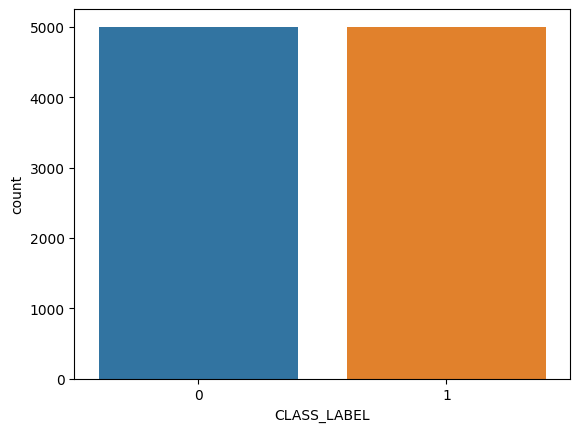

In [63]:
# Visualize the distribution of the target variable (CLASS_LABEL)
sns.countplot(x='CLASS_LABEL', data=df)
plt.show()

# Spearman Correlation

By looking the spearman correlation, we can find which features are linearly correlated in terms of predicting if a site is phising or not.

Creating a heatmap to show how selected columns from index idx_s to idx_e correlate in the dataset. It checks for the 'id' column and includes the target variable 'CLASS_LABEL', giving us a visual insight into feature relationships. The annotated values offer a quick understanding of correlation strength.

In [64]:
def corr_heatmap(data, idx_s, idx_e):
    y = data['CLASS_LABEL']
    temp = data.iloc[:, idx_s:idx_e]
    if 'id' in temp.columns:
        del temp['id']
    temp['CLASS_LABEL'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()

# First 10 columns

By looking at the first 10 columns against labels, we can concluded that non of the features have strong correlation with the labels, however, NumDash has some significant negative effect towards the labels, which could mean if there is less number of dash then it is more likely to be phising site

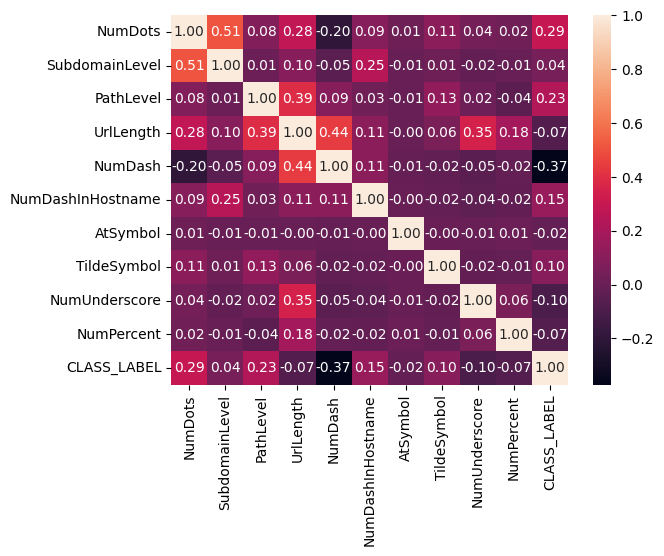

In [65]:
corr_heatmap(df, 0, 10)

# Columns 10 to 20

There are no strong or even medium level strength correlation features with labels

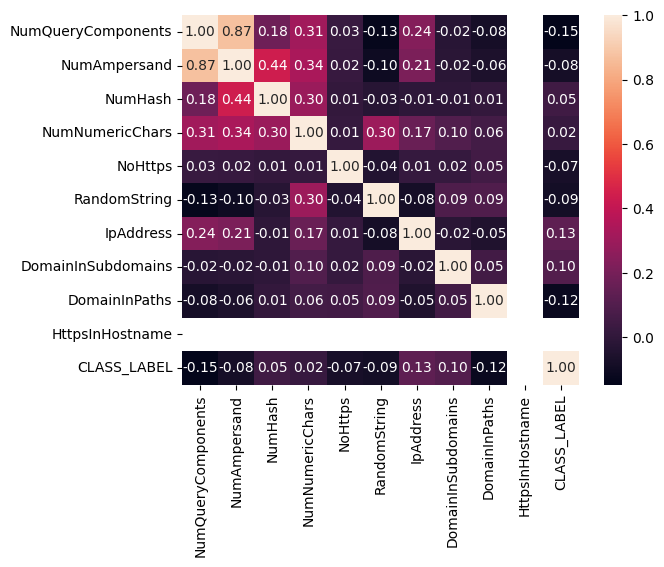

In [66]:
corr_heatmap(df, 10, 20)

# Columns 20 to 30

Still no strong correlation feature

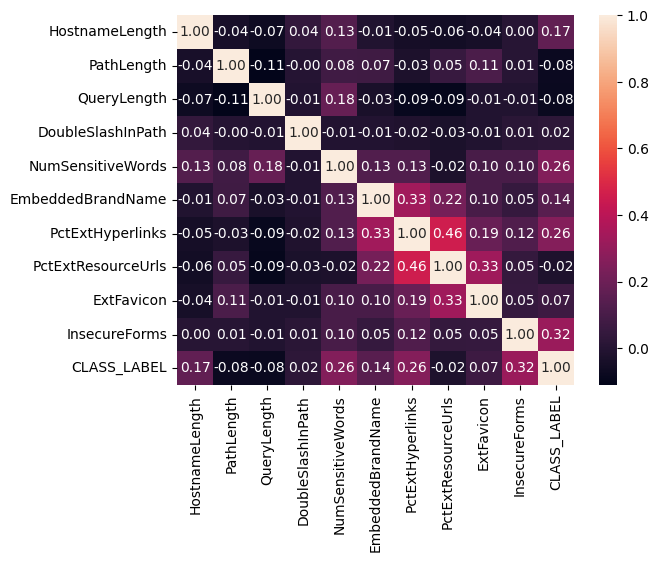

In [67]:
corr_heatmap(df, 20, 30)

# Columns 30 to 40

Well here we have a few features that are linearly correlated to our dep variable

* InsecureForms shows that as the value is higher so the probability of being a phising site
* PctNullSelfRedirectHyperlinks shows the same positive correlation as InsecureForms
* FequentDomainNameMismatch shows that it has medium linear correlation in positive direction
* SubmitInfoToEmail seems to indicate that sites that ask users to submit their details to emails seems to be more high probability for phising

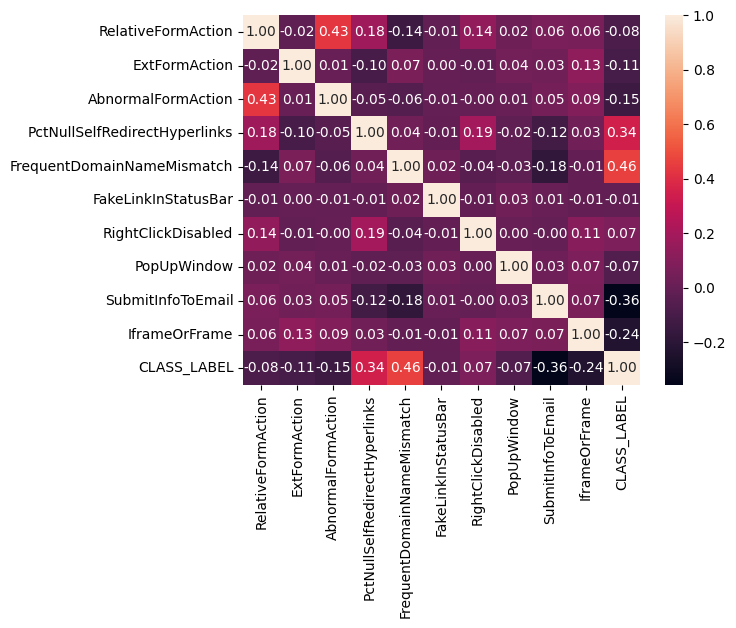

In [68]:
corr_heatmap(df, 30, 40)

# Columsn 40 to 50

The only column in this group that has some correlation with labels is PctExtNullSelfRedirectHyperlinksRT and it has negative effect towards labels which could mean that when the number of percent of null self redirect hyperlinks occur hence the probabiliy of phising increases

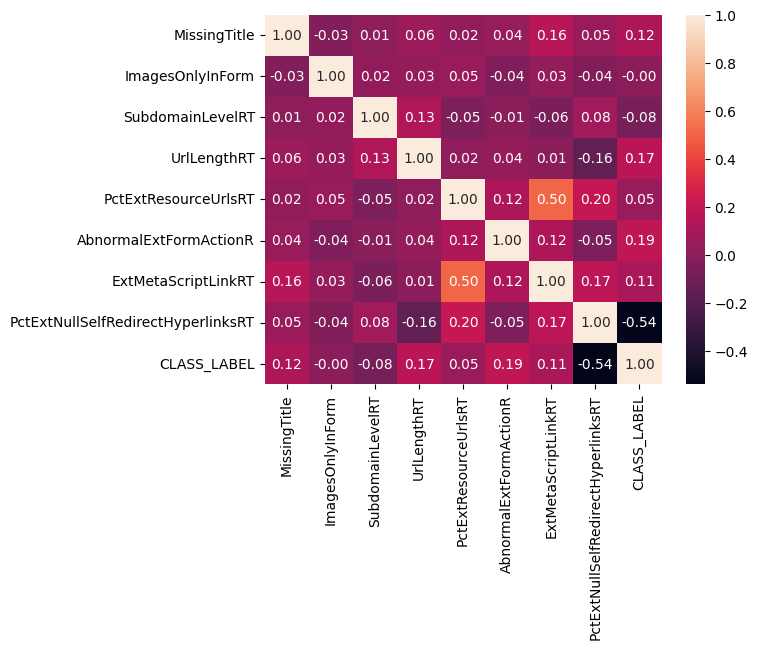

In [69]:
corr_heatmap(df, 40, 50)

## **Top Correlation features**

Identifying the top correlated features with the target variable, this code snippet selects the top 10 based on absolute correlation values. It then computes the correlation matrix for these features and visualizes it with a heatmap, providing a clear picture of the relationships among the most influential features. The resulting plot is a handy tool for understanding the significant correlations within the dataset.

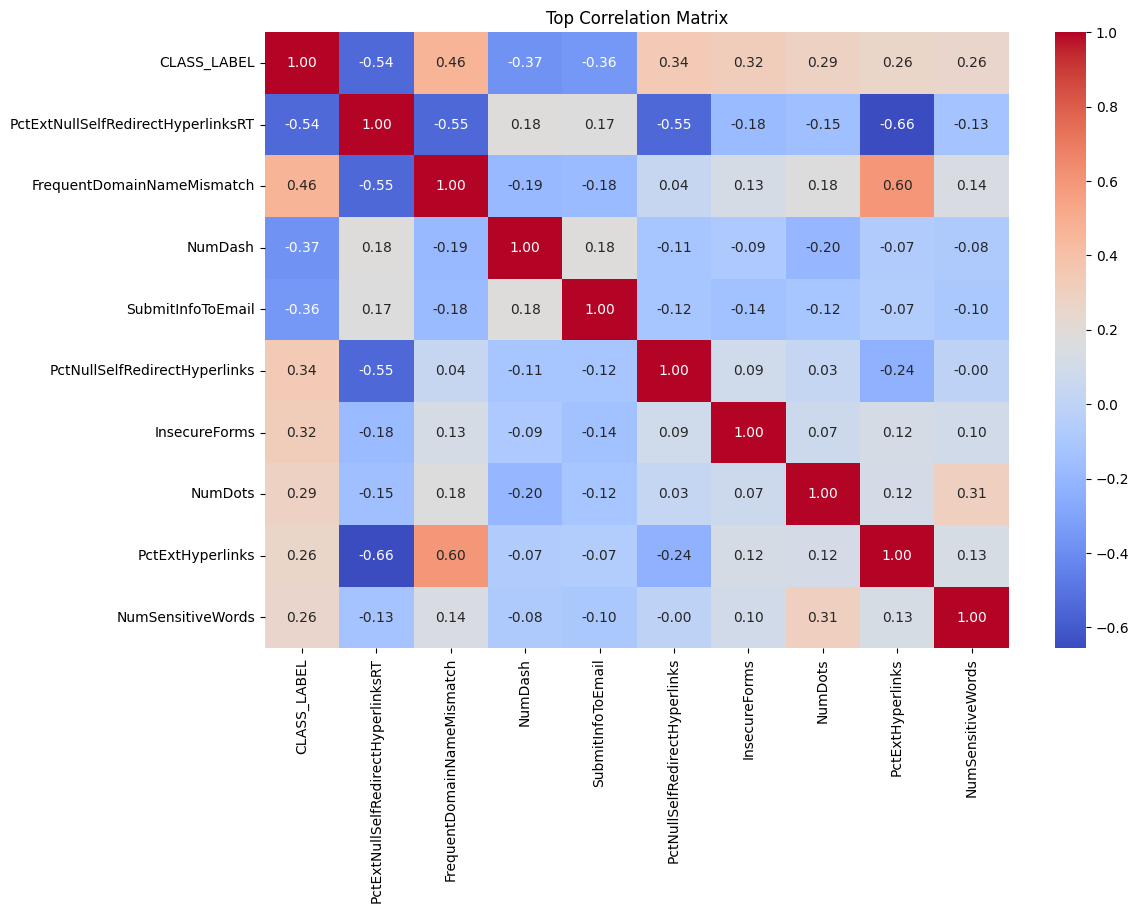

In [70]:
# Select the top correlated features with the target variable
top_correlation_features = df.corr()['CLASS_LABEL'].abs().sort_values(ascending=False).head(10).index

# Compute the correlation matrix for top features
top_corr_matrix = df[top_correlation_features].corr()

# Plot the correlation heatmap for top features
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top Correlation Matrix')
plt.show()


## **Histograms for All Numeric Features:**

This code generates histograms for all numeric features in the dataset. It iterates through each numeric column, creating a visual representation of their distribution with 30 bins and kernel density estimation. The resulting plots provide a quick overview of the data distribution for each numerical feature.

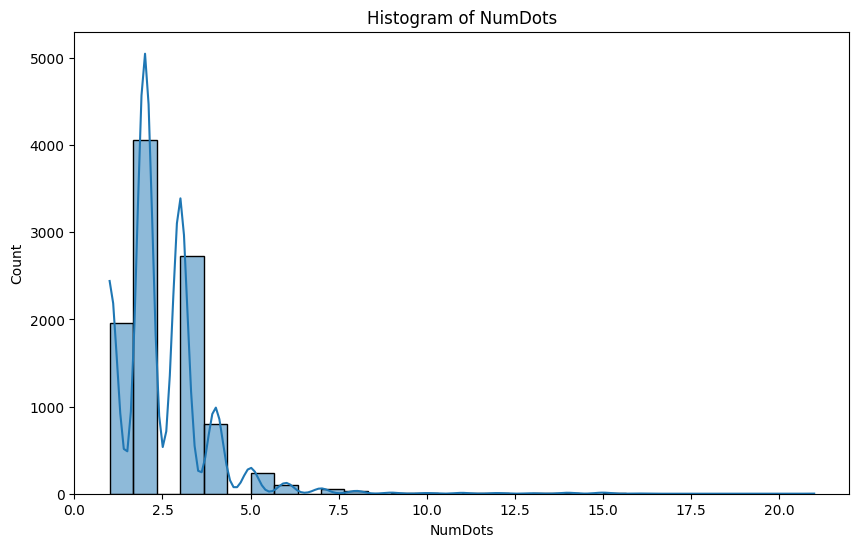

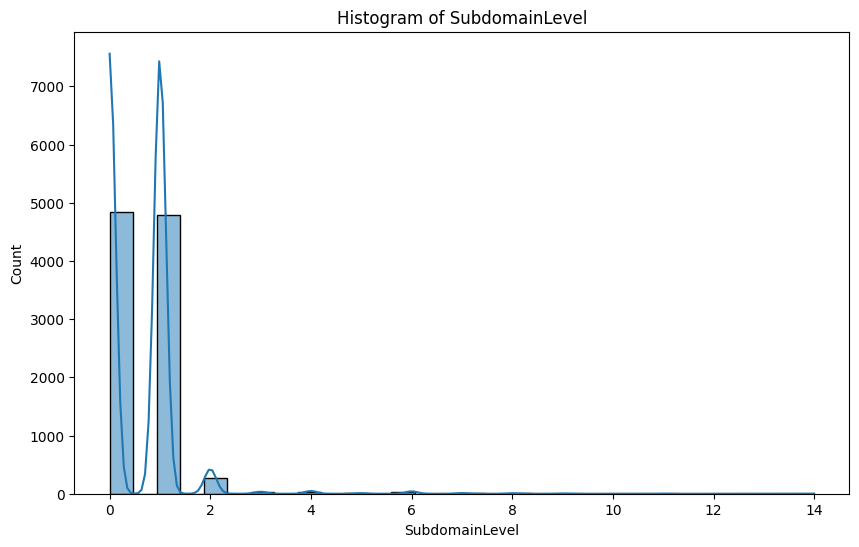

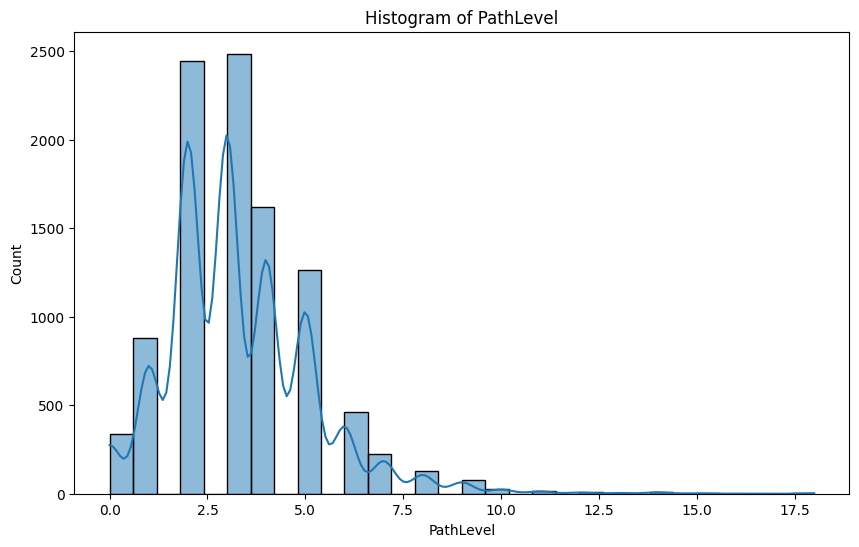

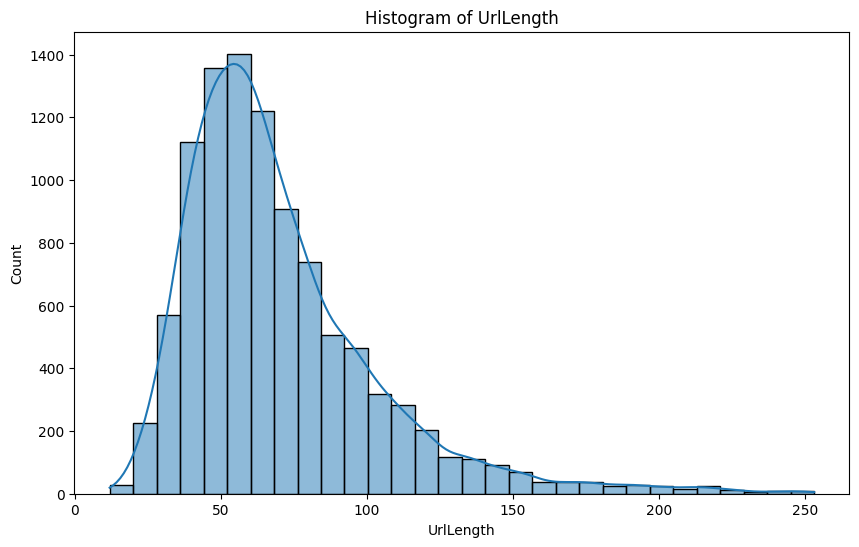

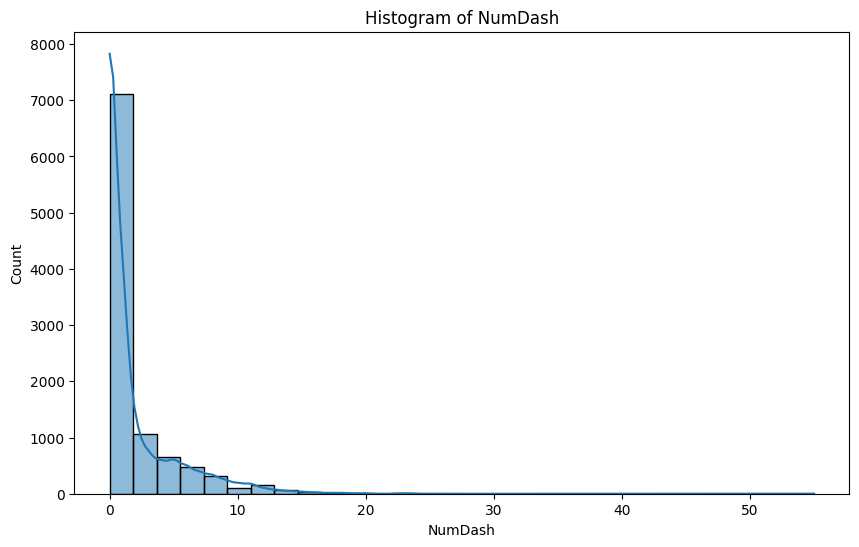

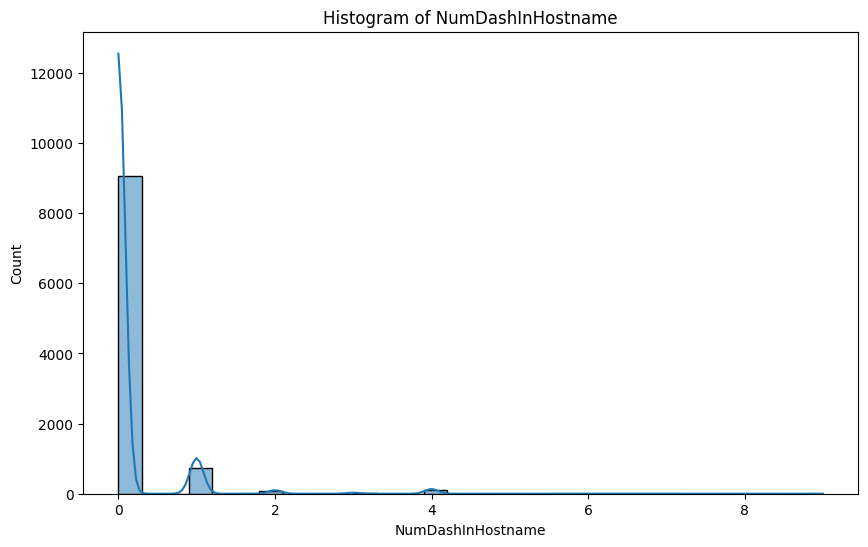

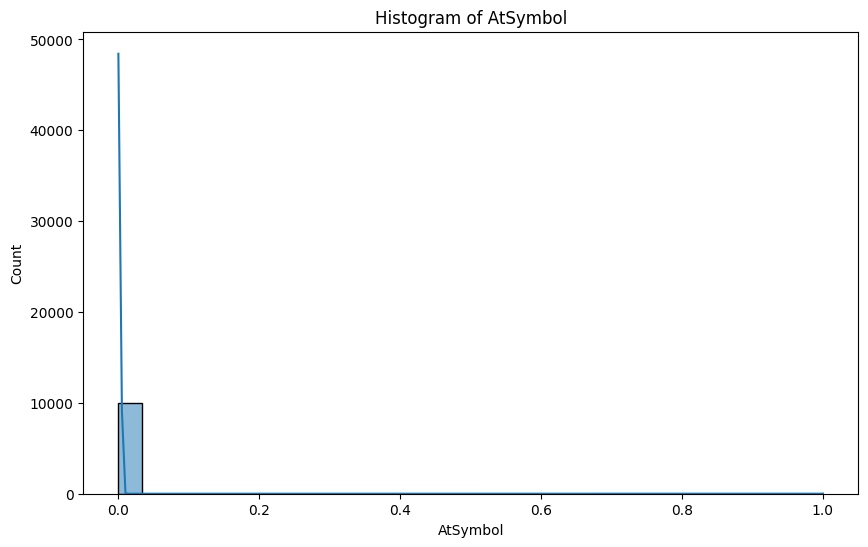

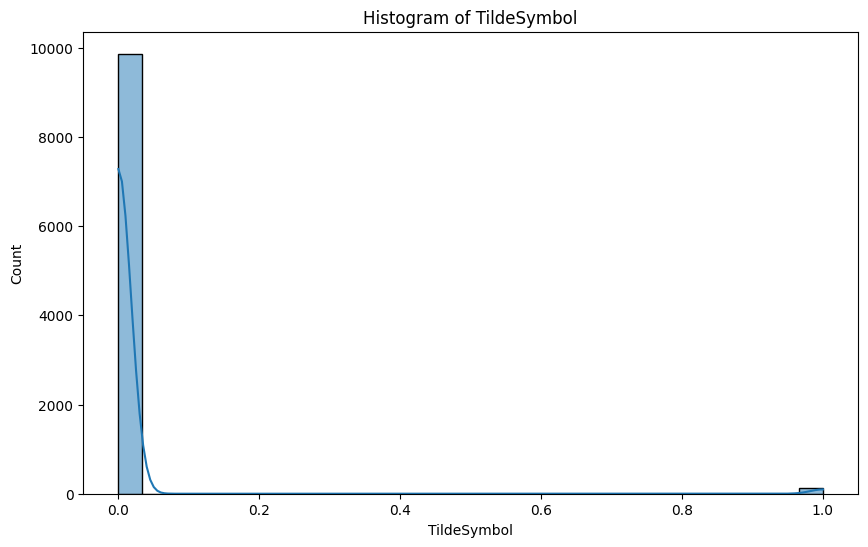

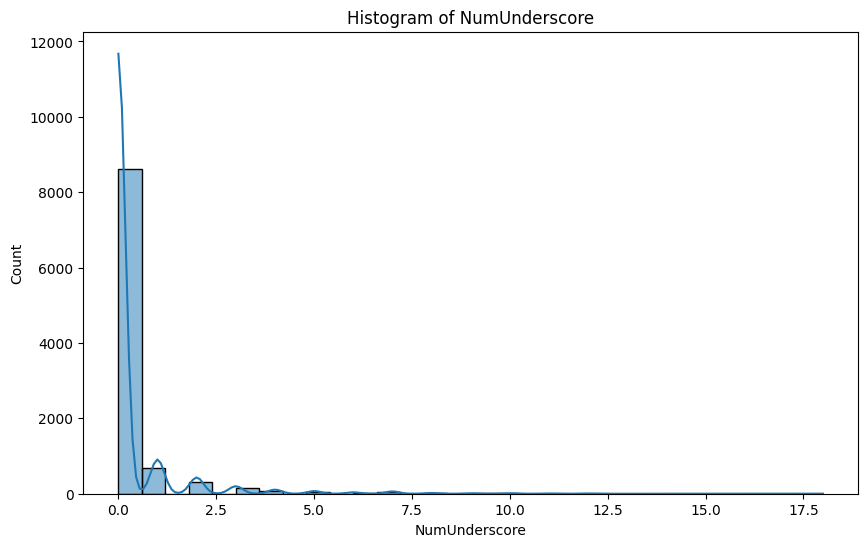

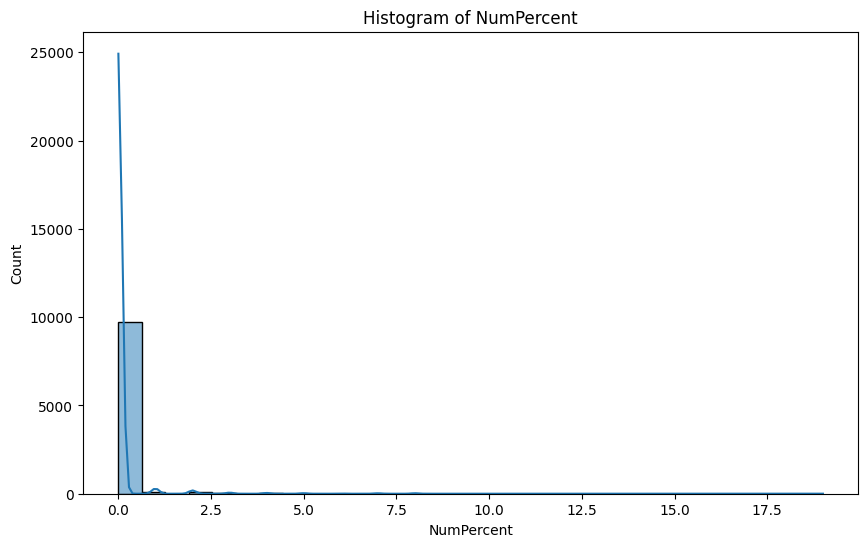

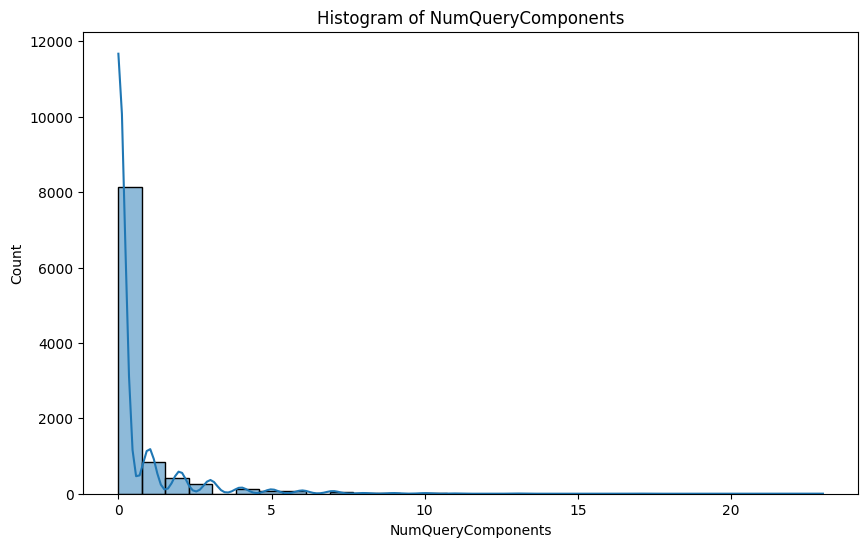

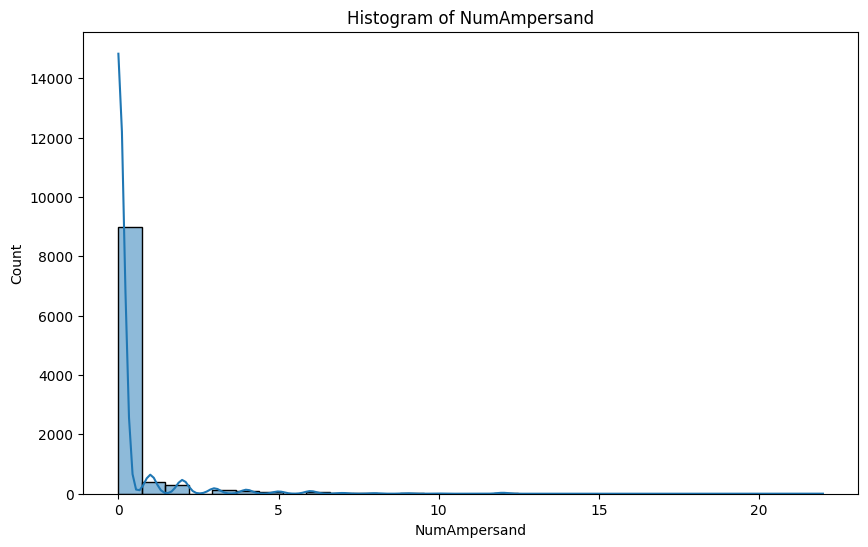

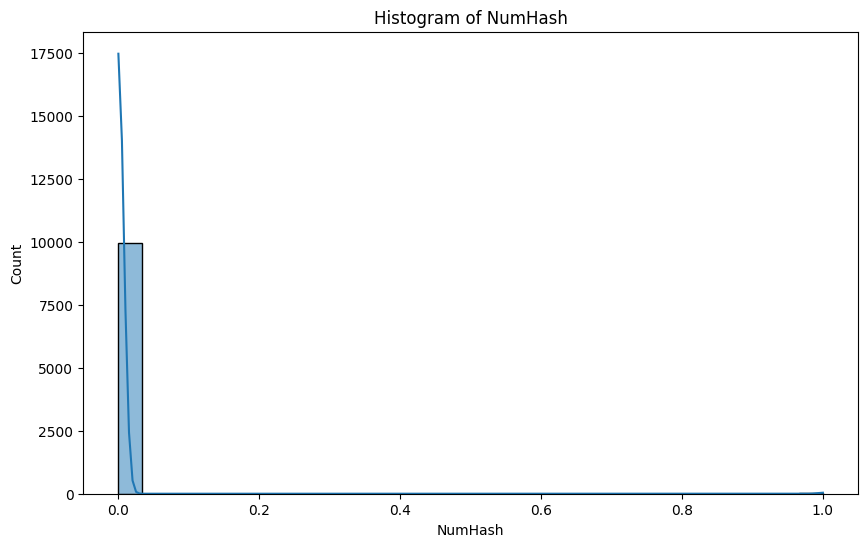

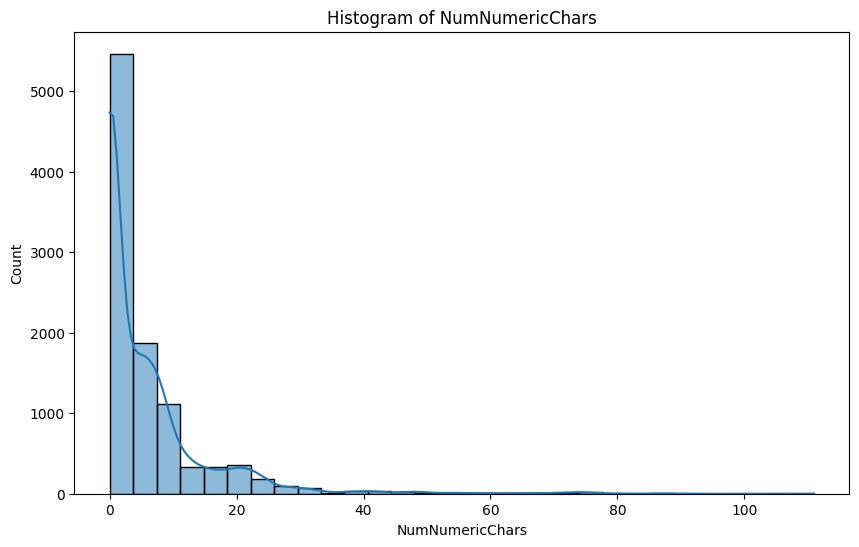

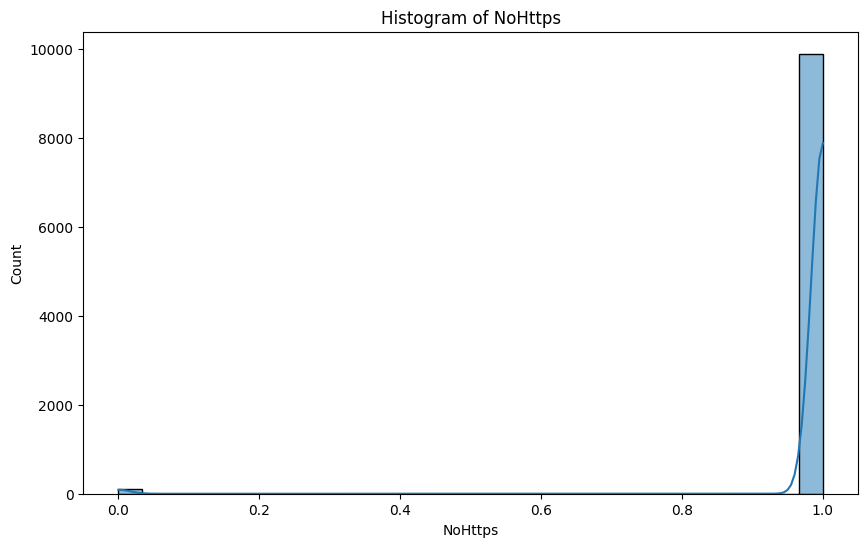

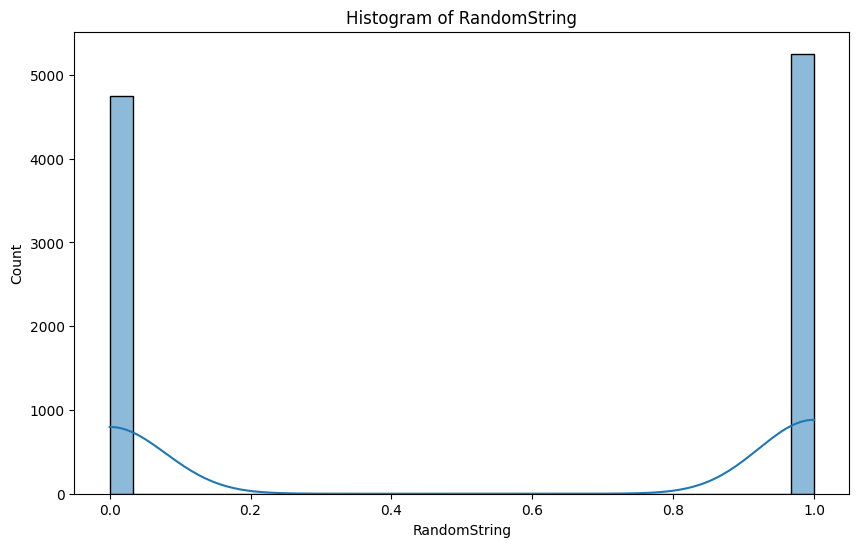

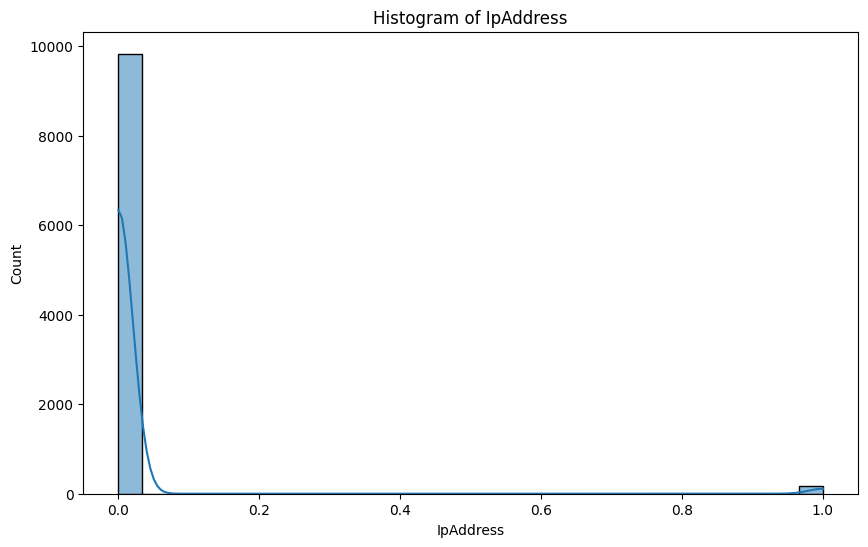

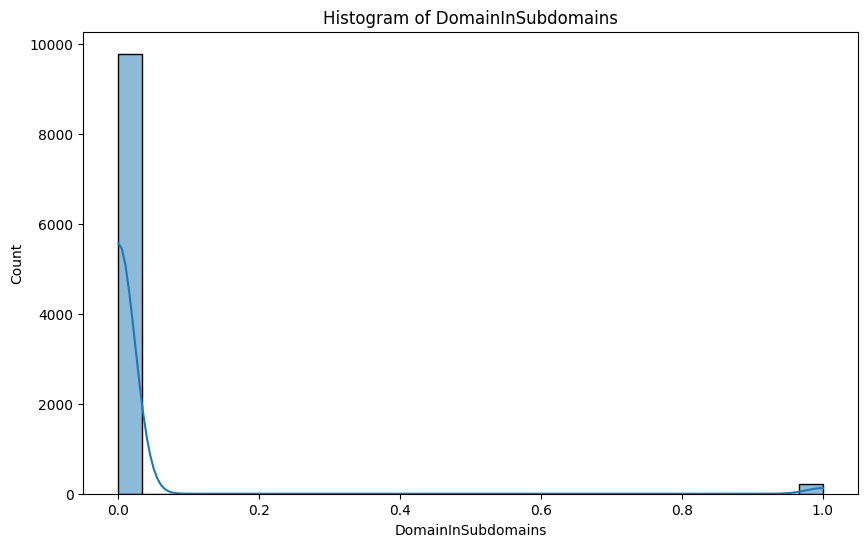

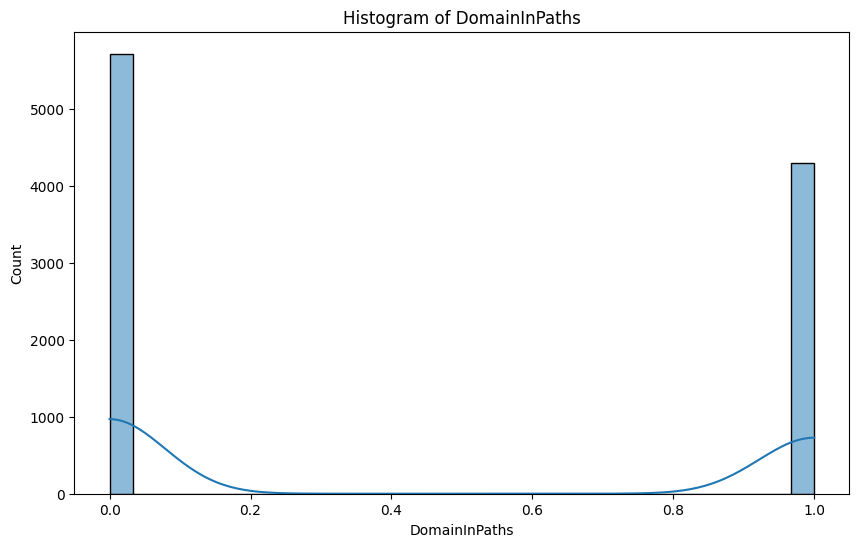

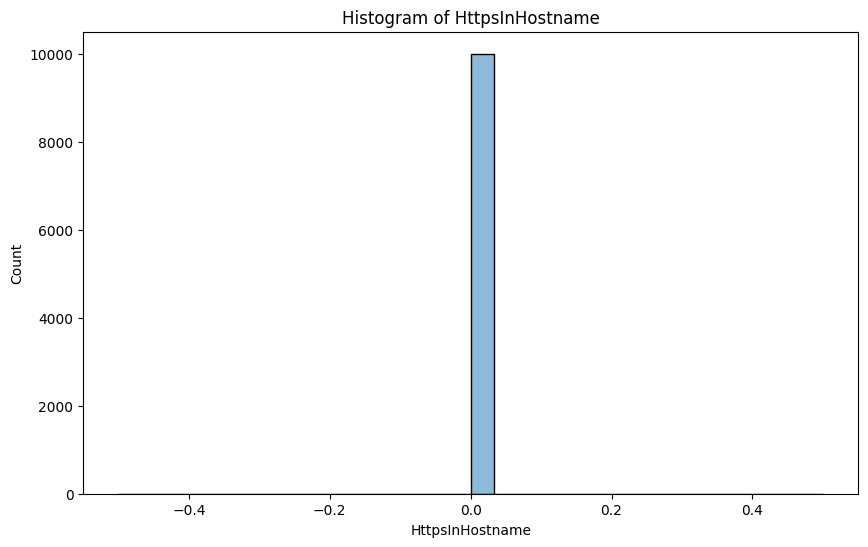

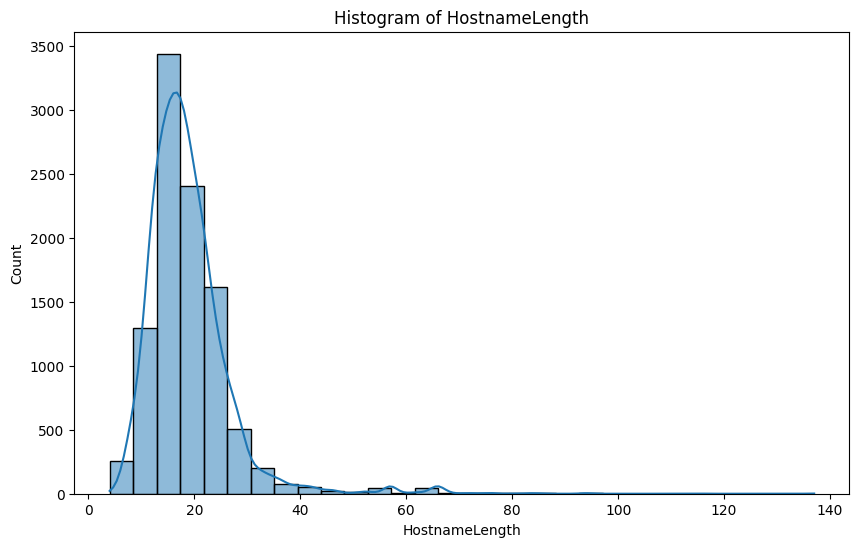

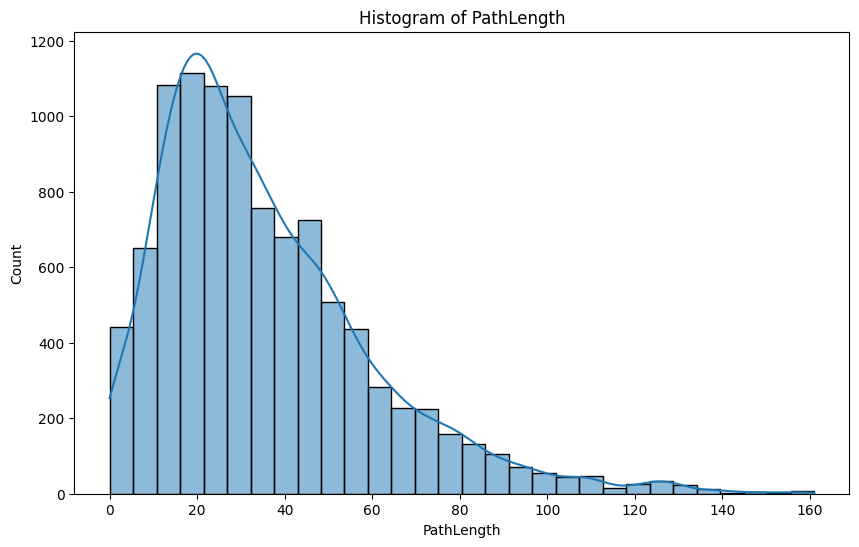

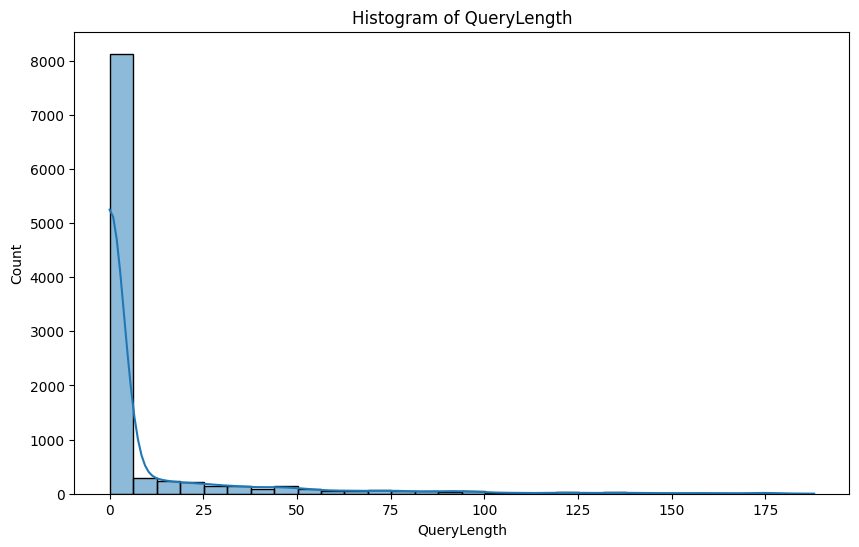

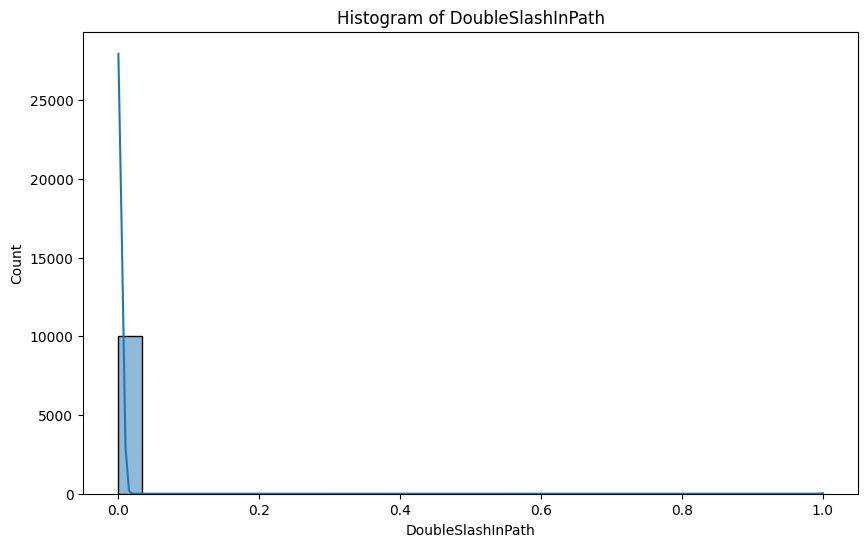

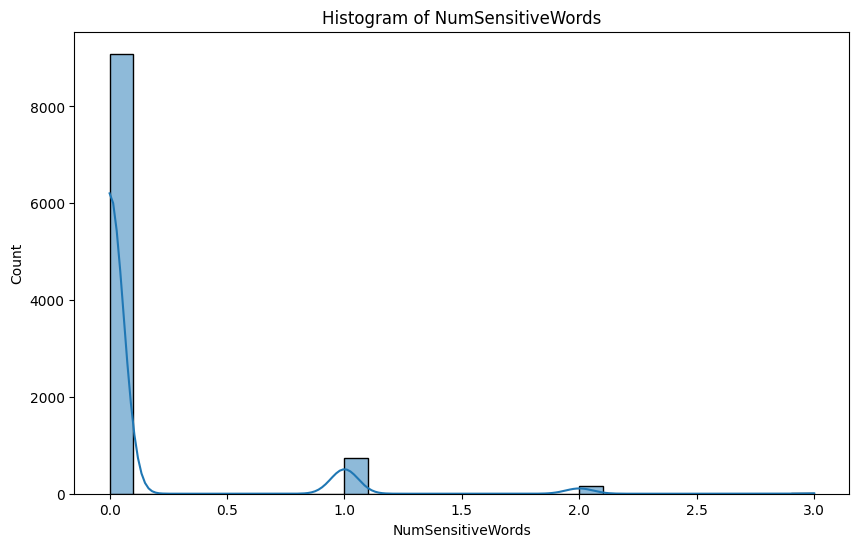

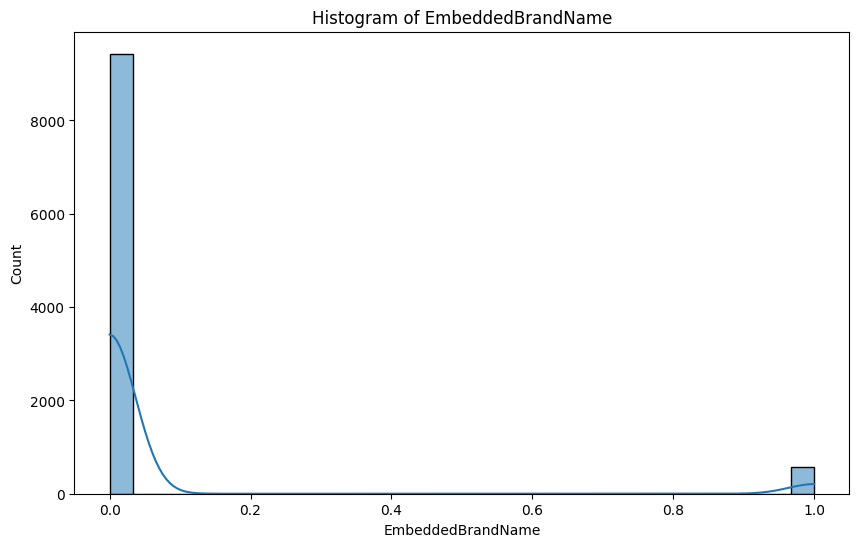

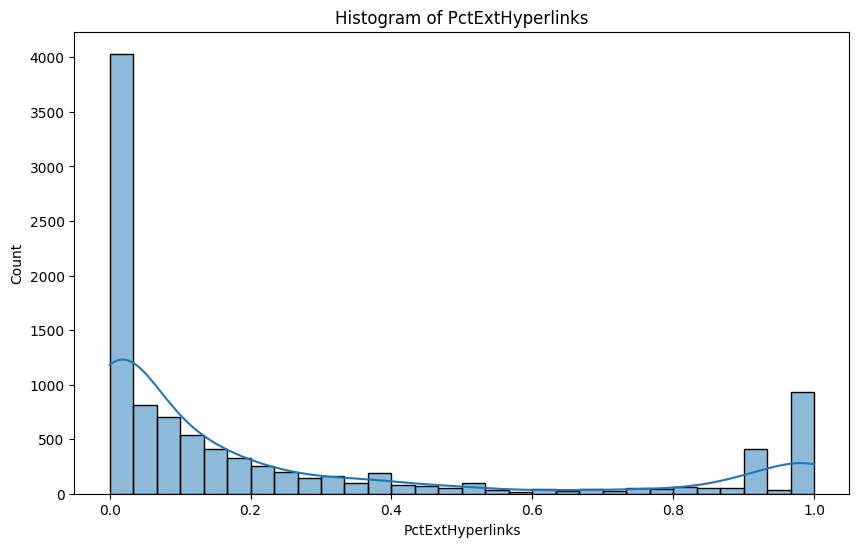

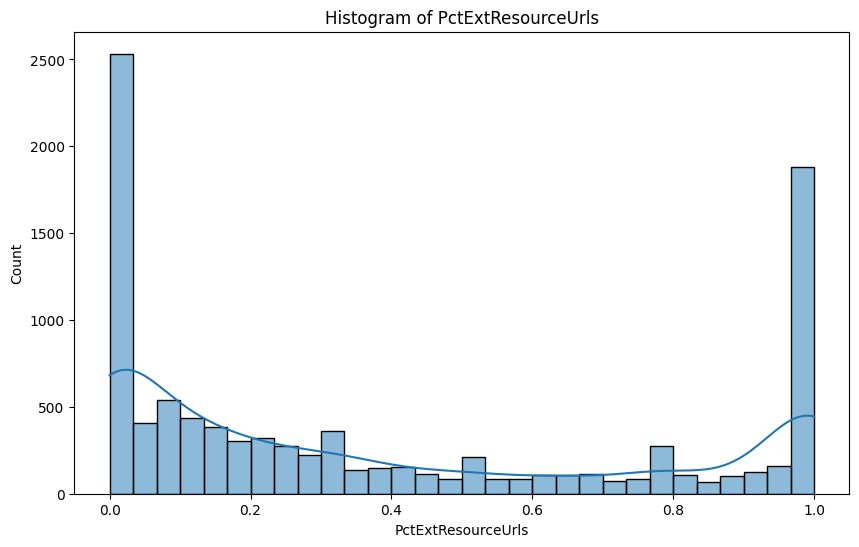

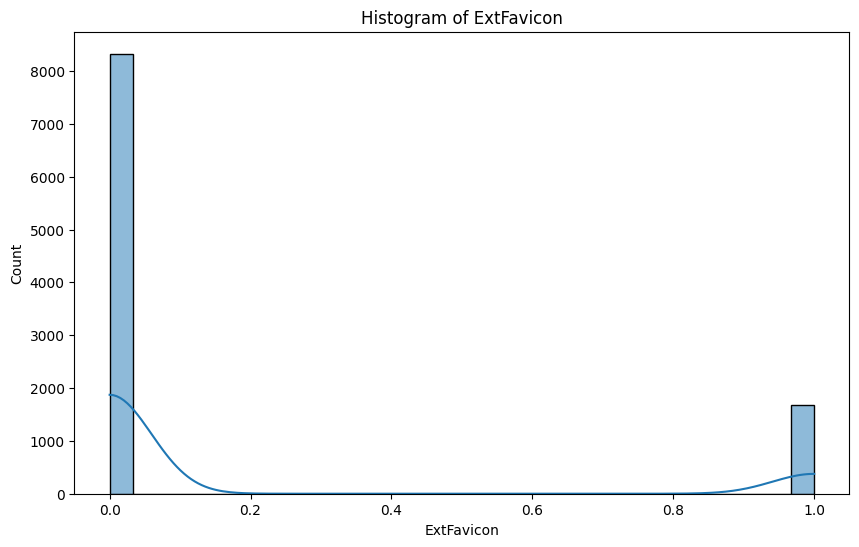

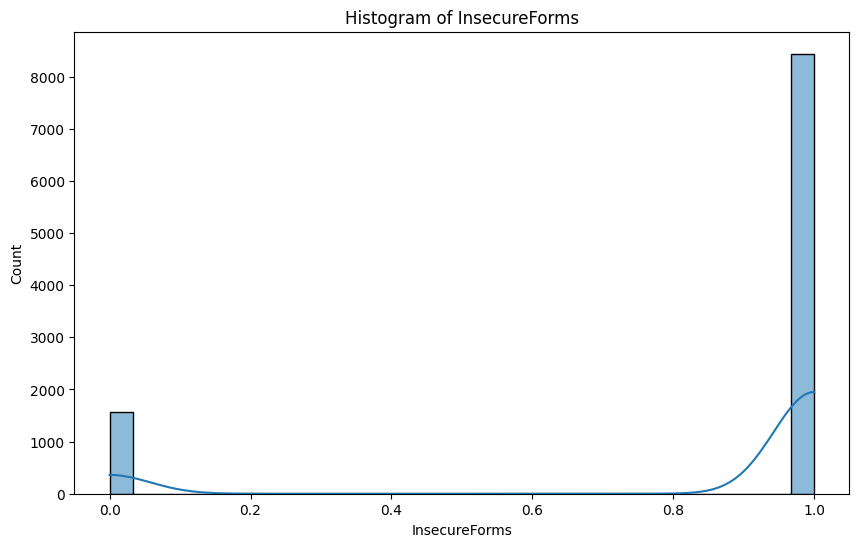

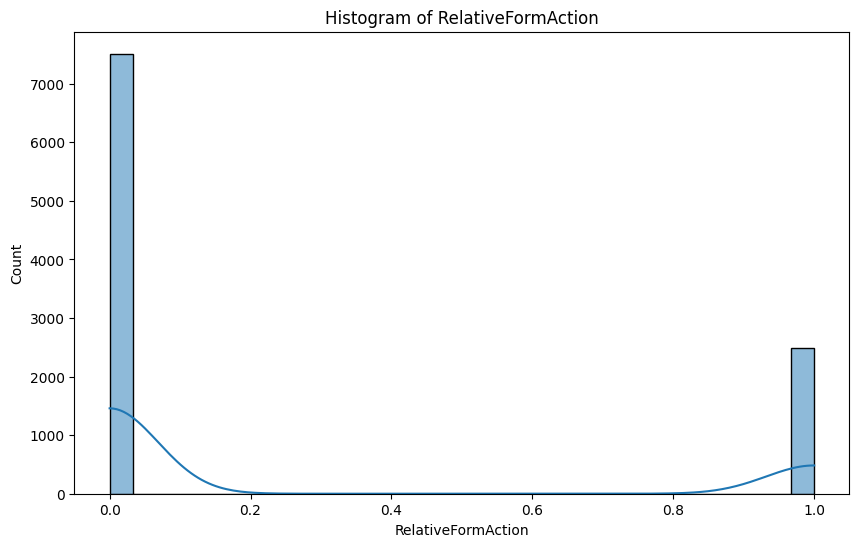

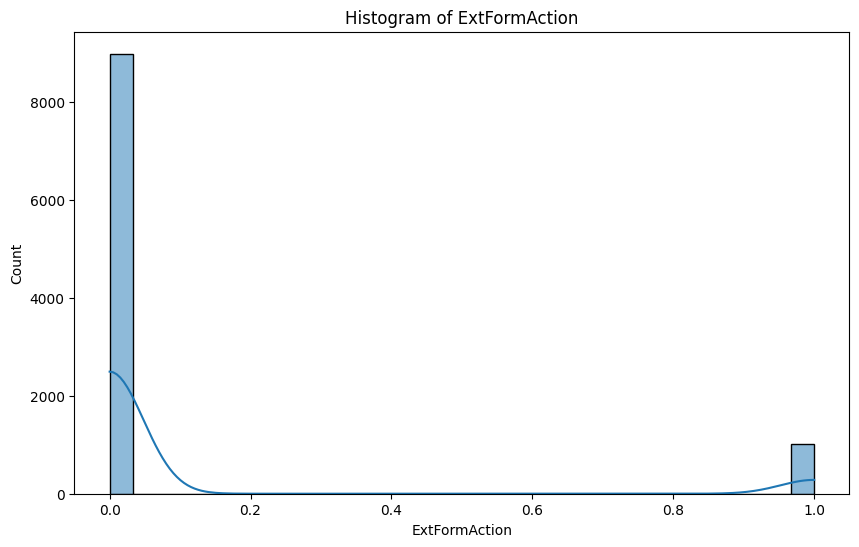

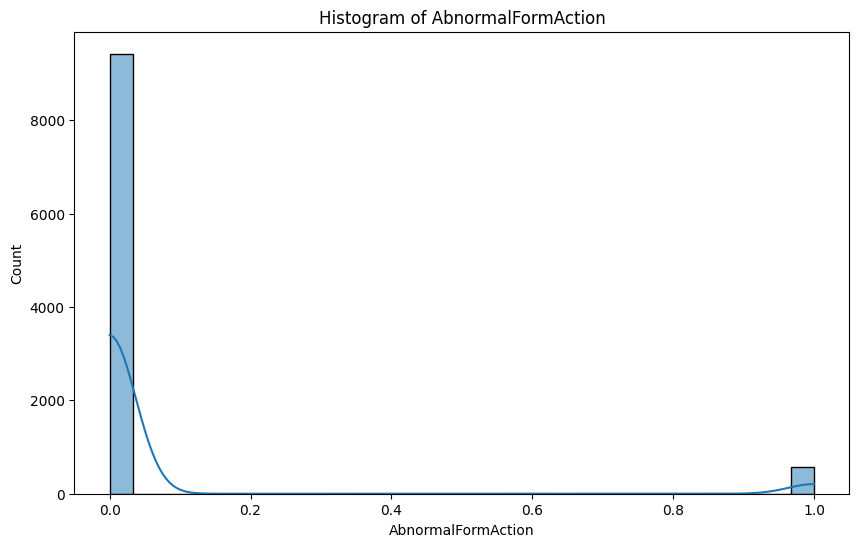

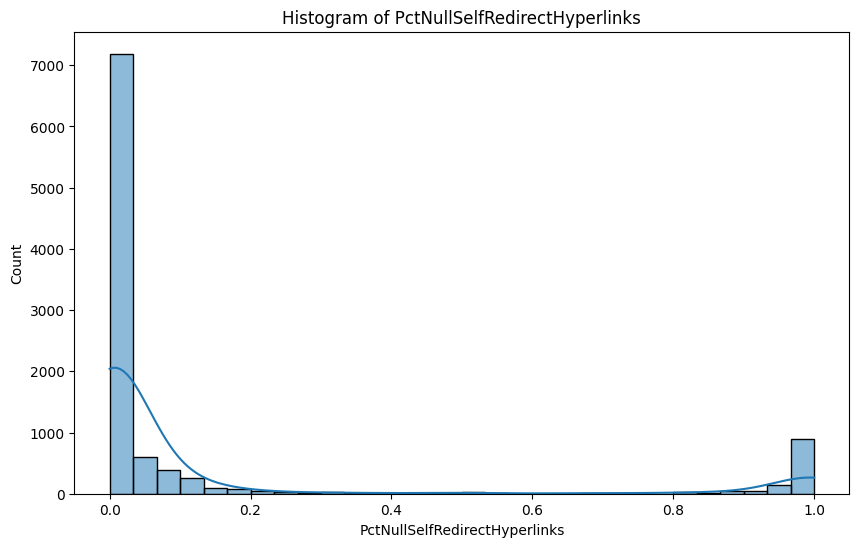

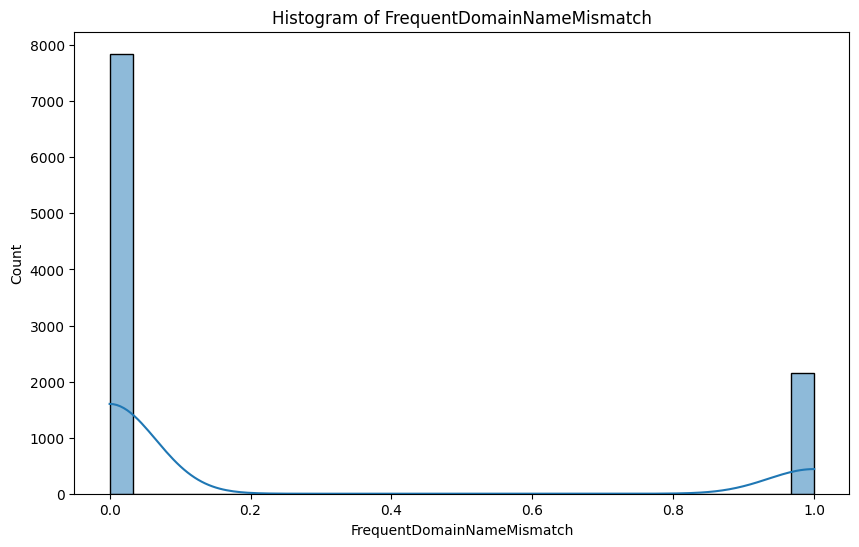

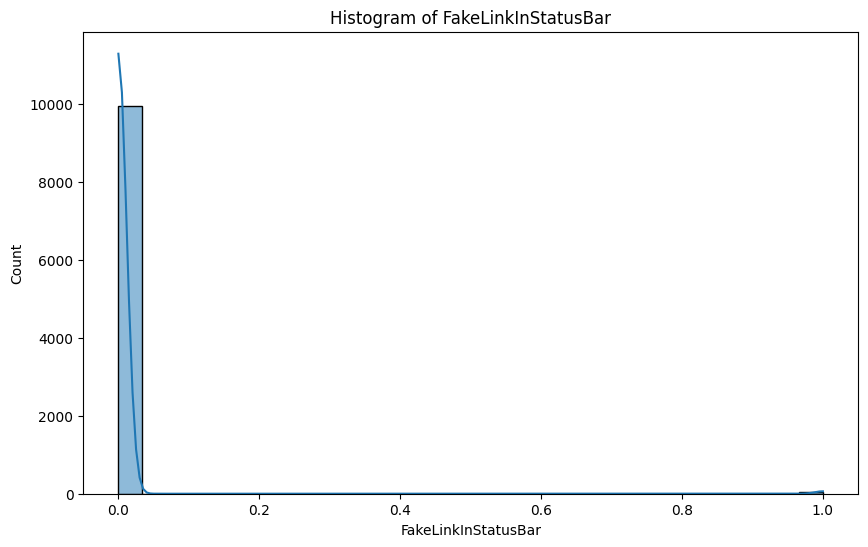

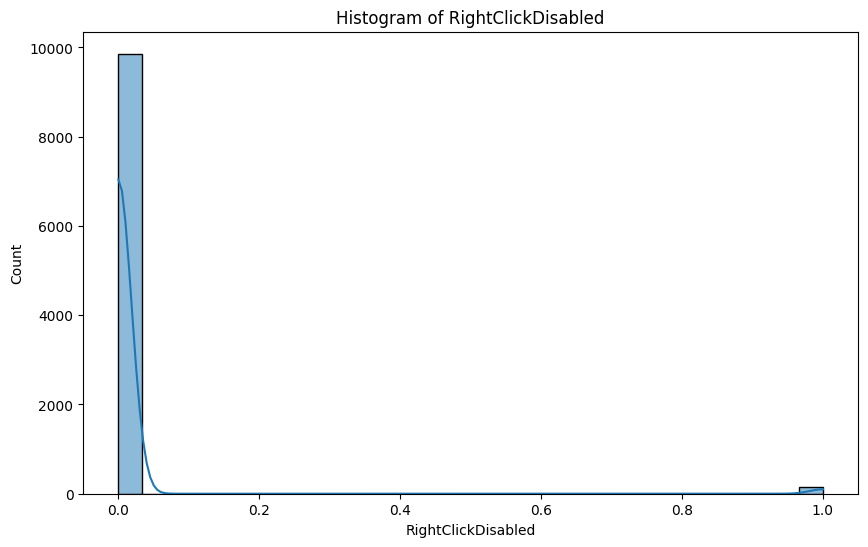

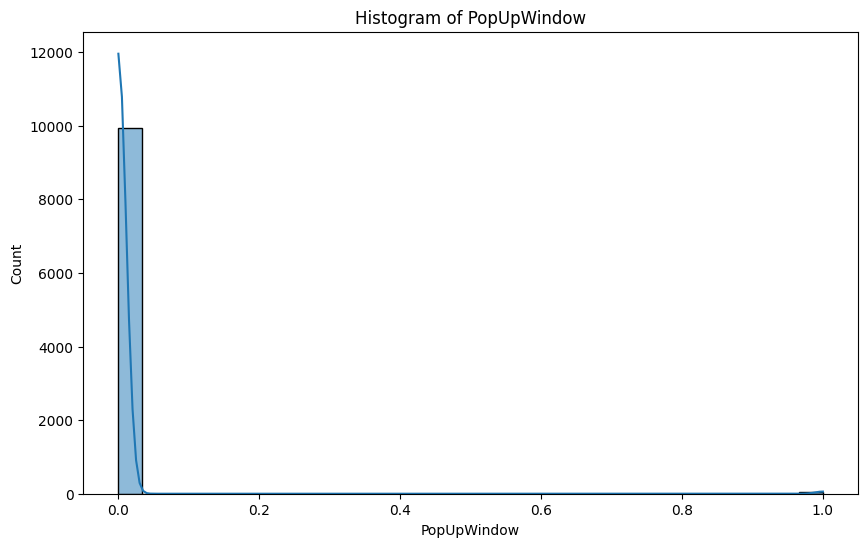

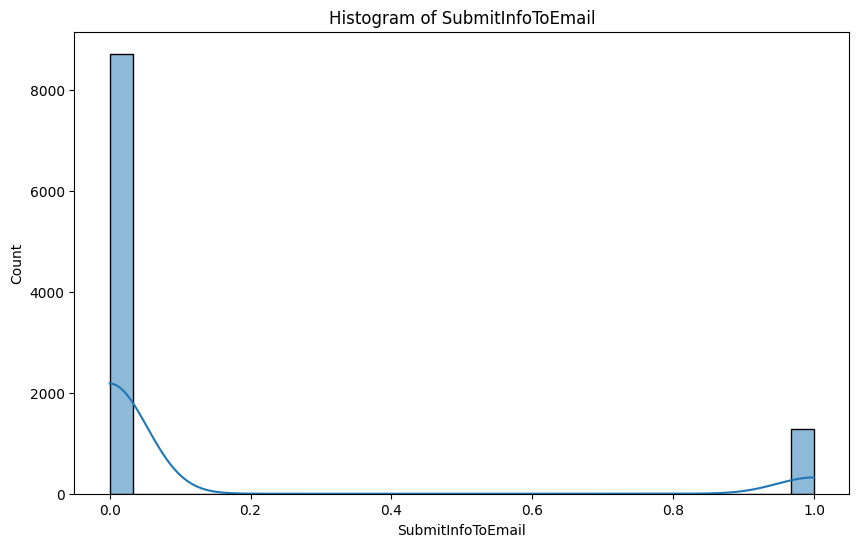

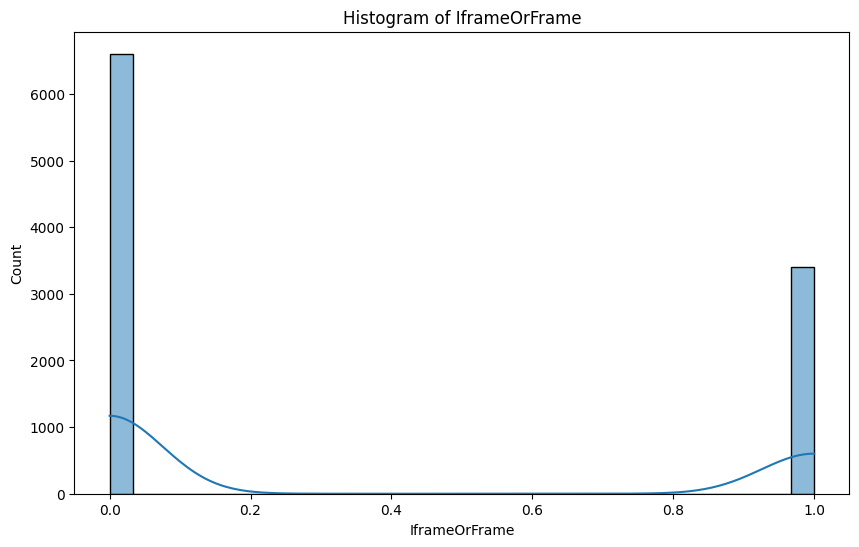

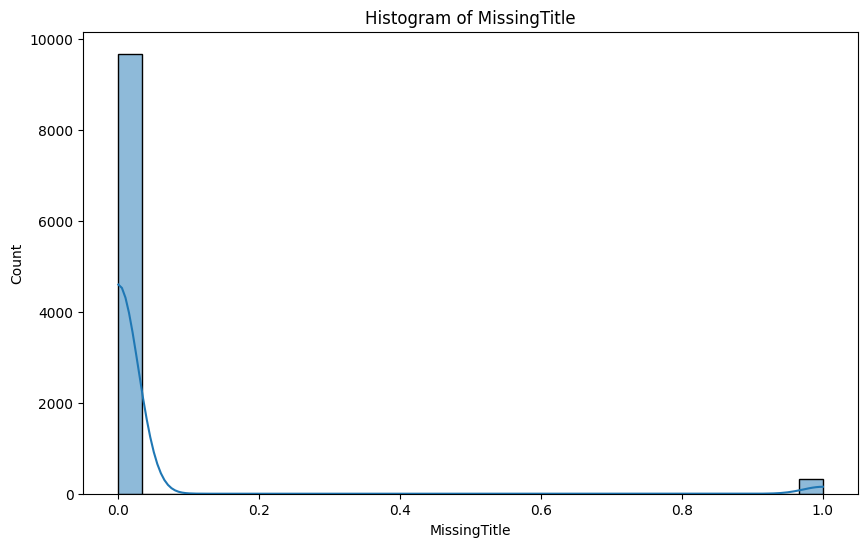

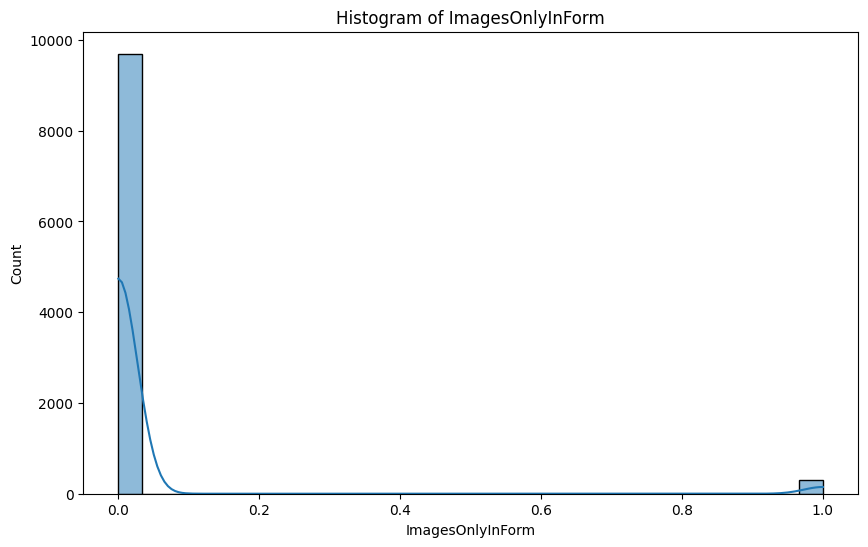

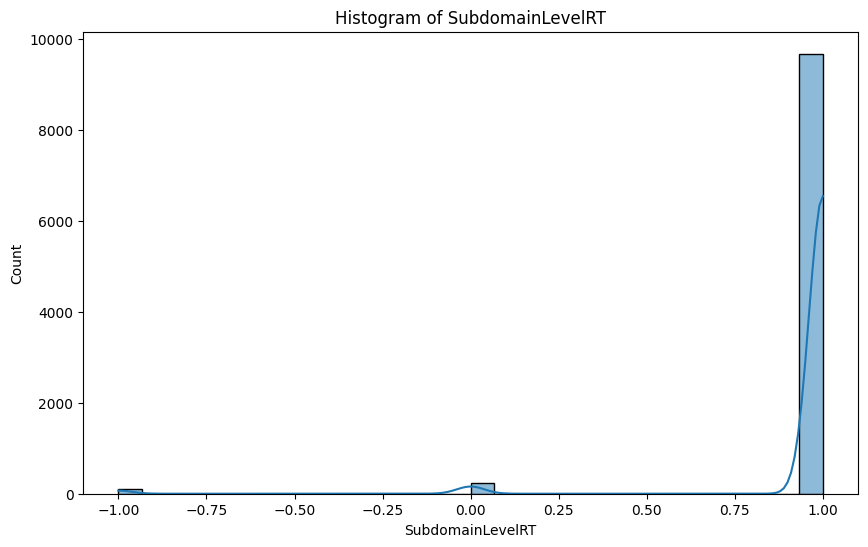

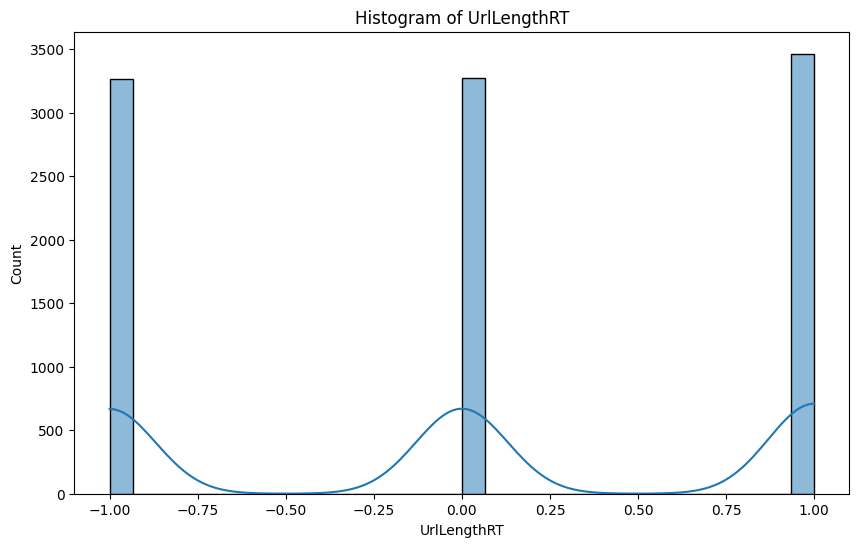

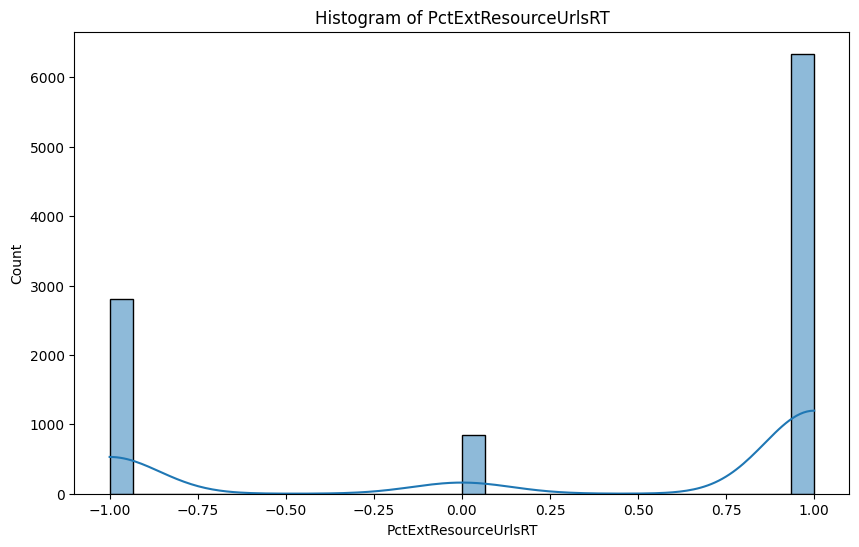

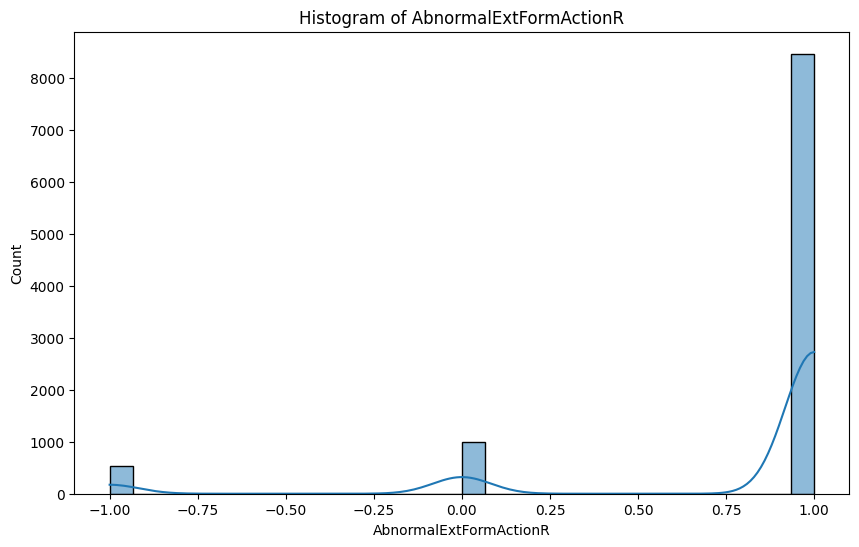

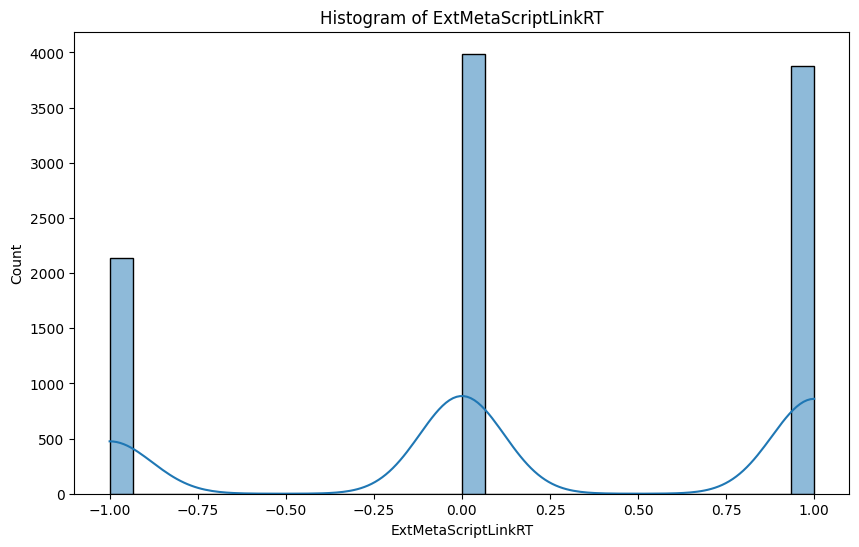

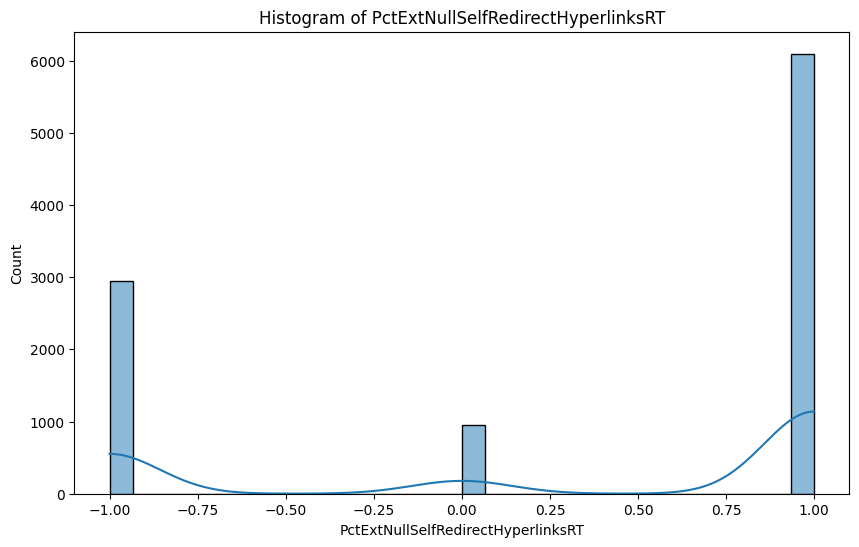

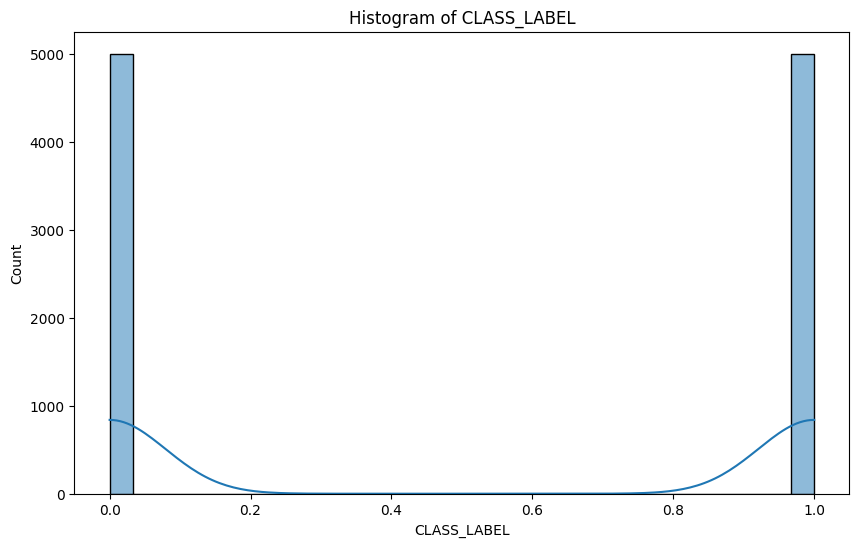

In [71]:
# Histograms for all numeric features
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()


### **Boxplots for All Numeric Features by CLASS_LABEL:**

Generating boxplots for all numeric features based on the target variable (CLASS_LABEL), this code creates individual visualizations for each numerical column. The boxplots provide insights into the distribution and central tendency of each feature across different classes. It's a helpful way to understand how these numeric features vary with respect to the target variable.

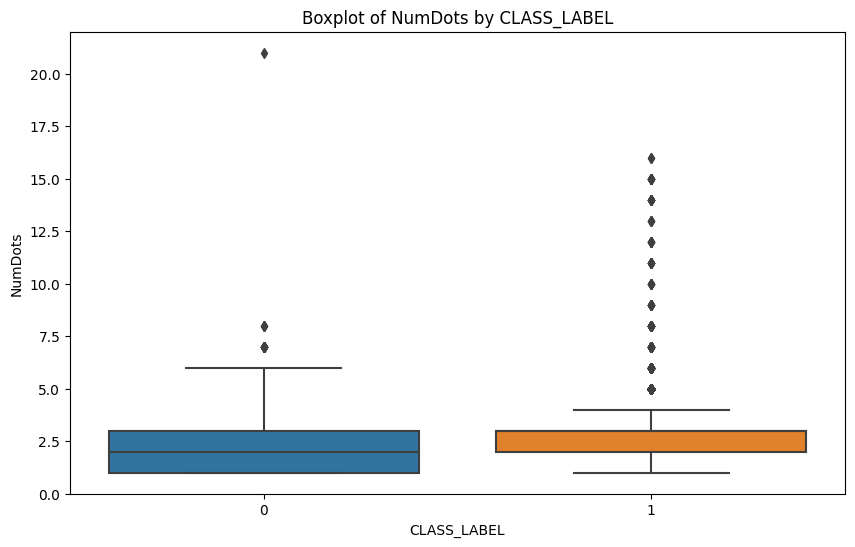

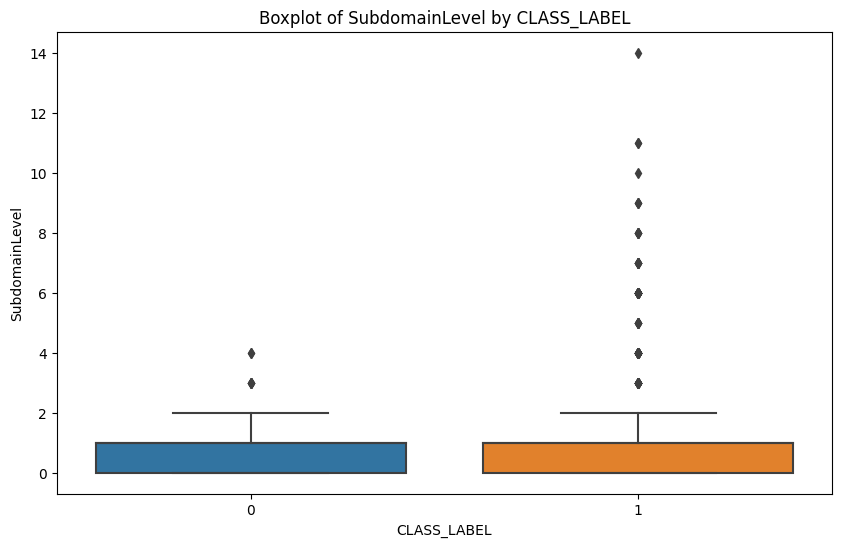

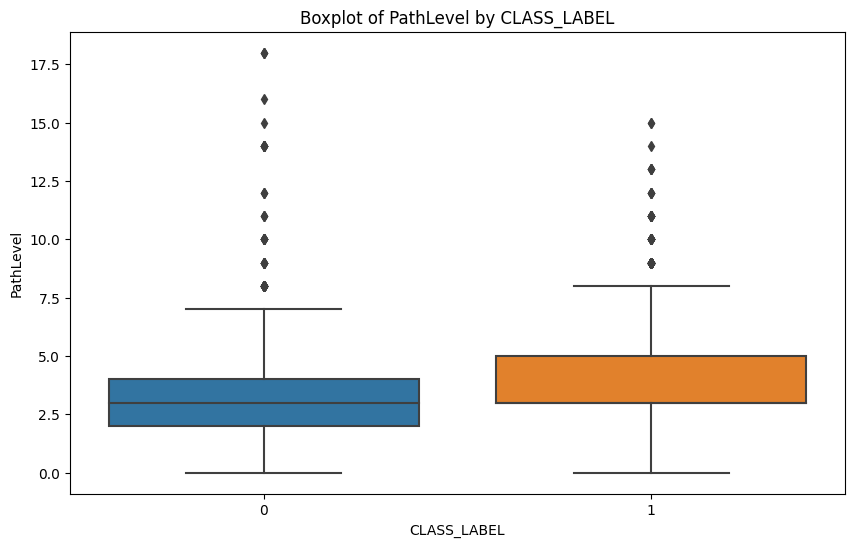

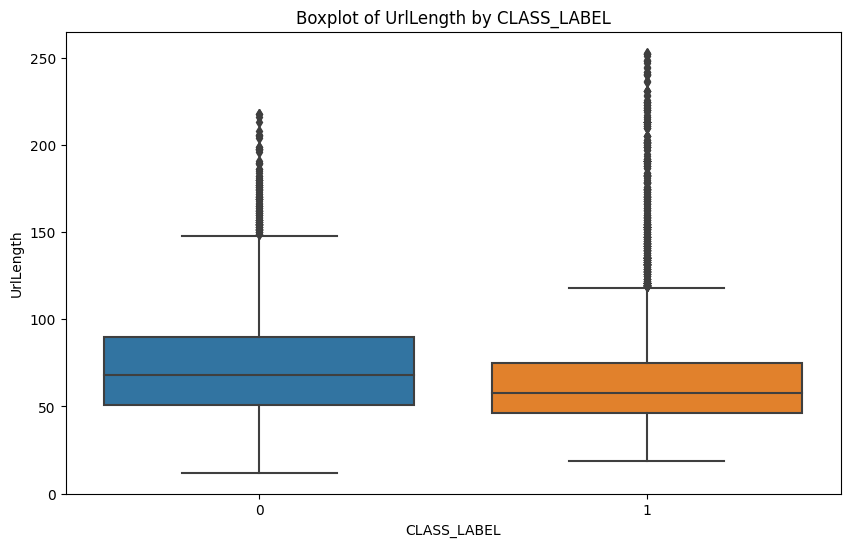

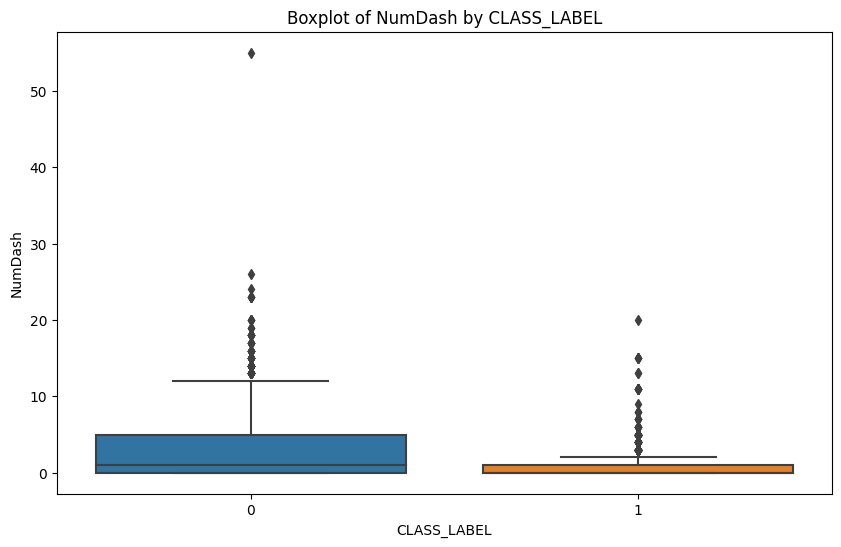

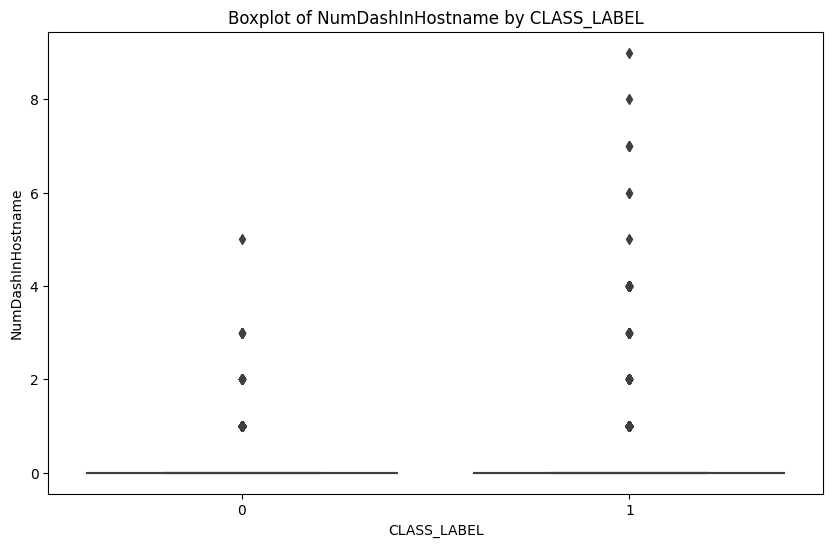

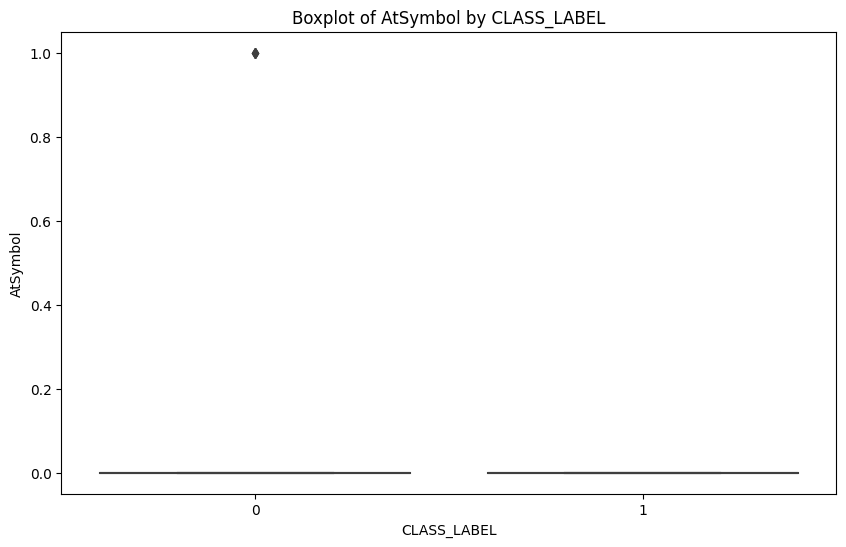

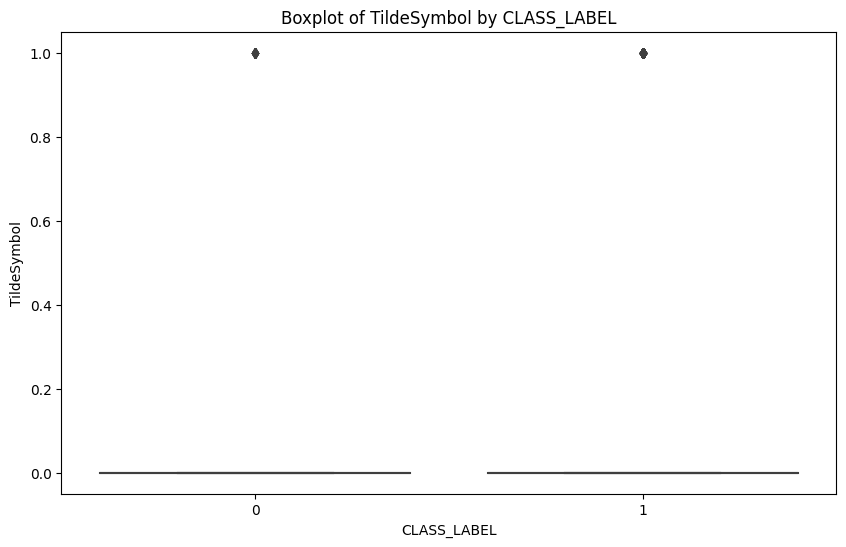

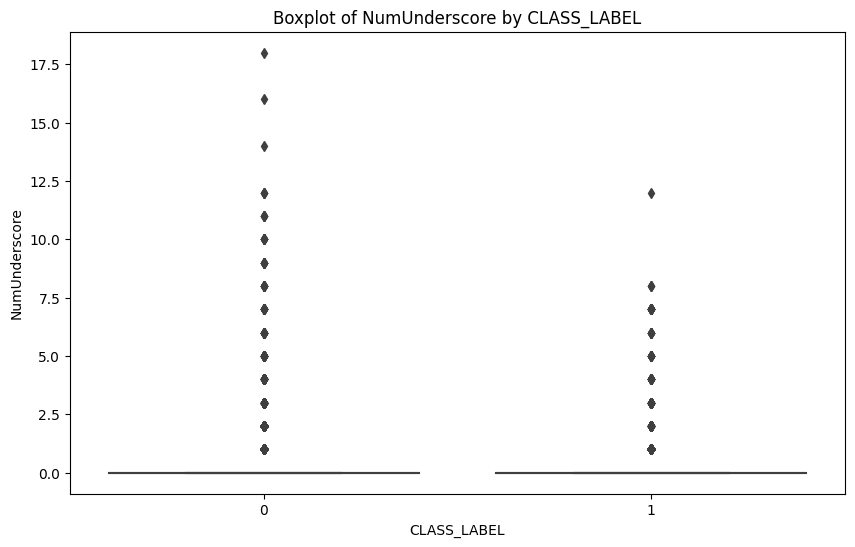

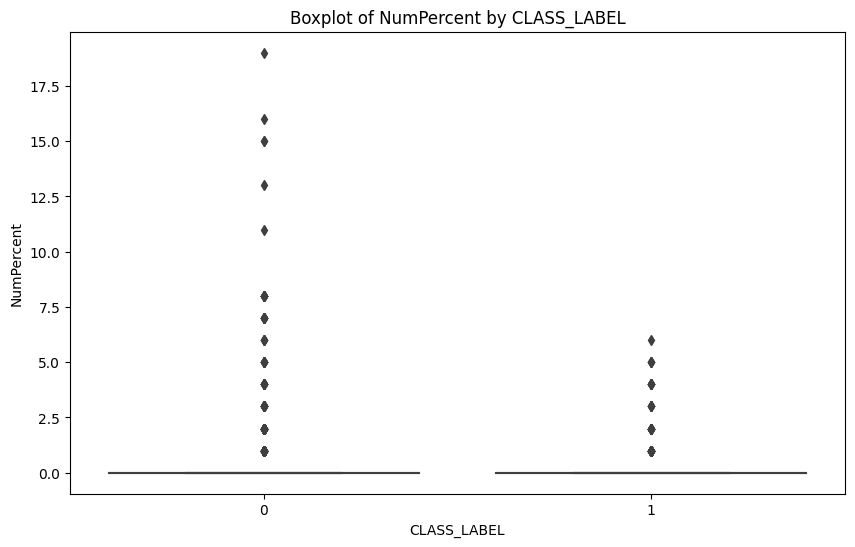

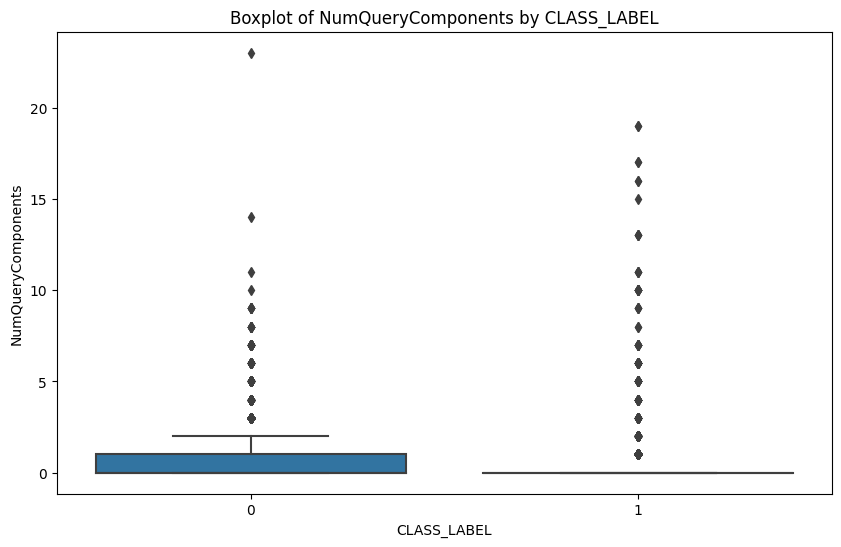

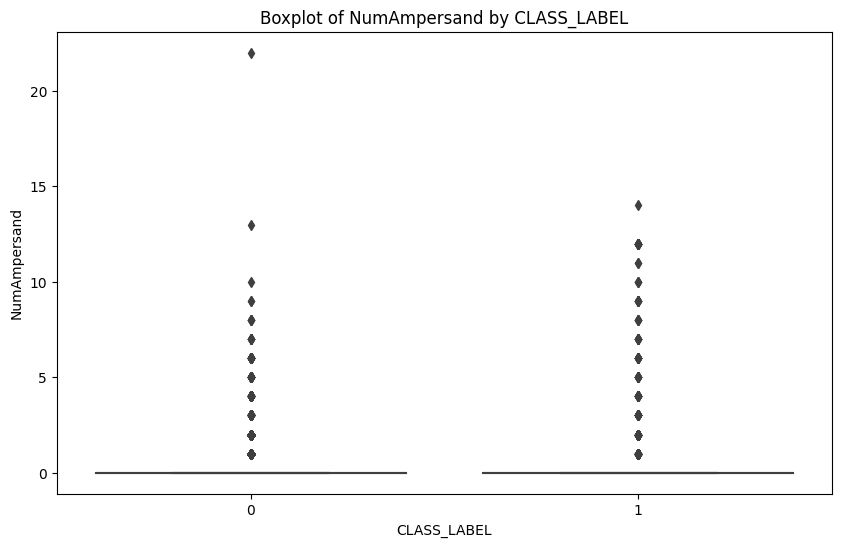

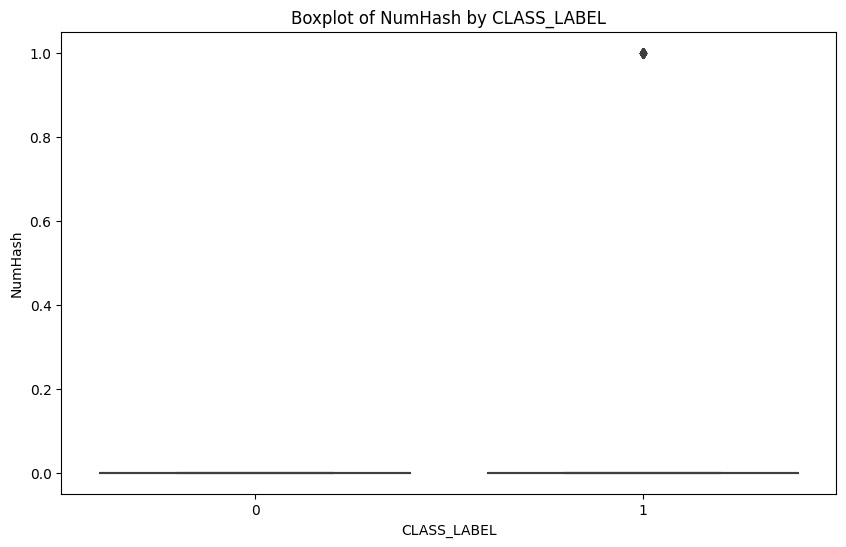

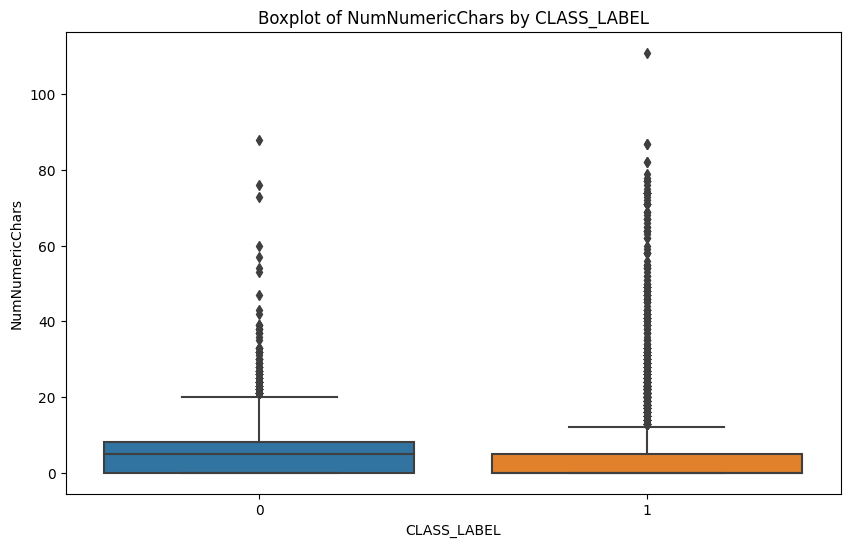

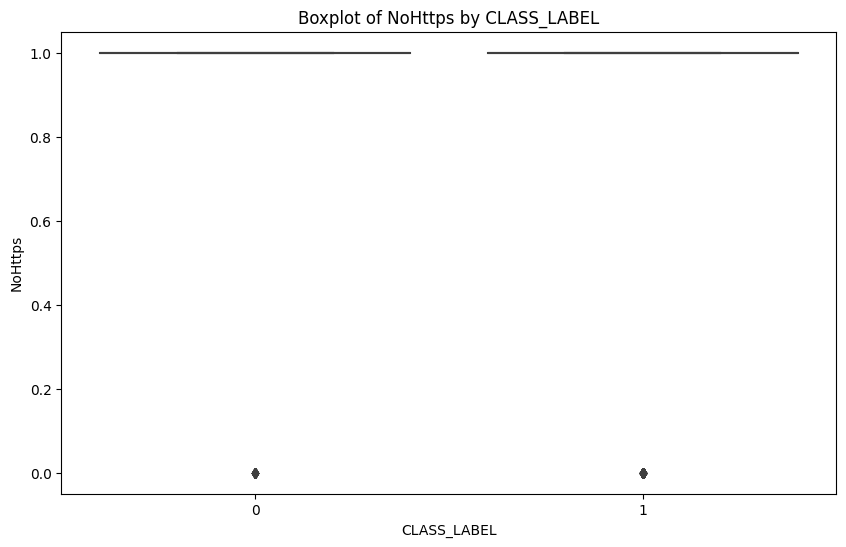

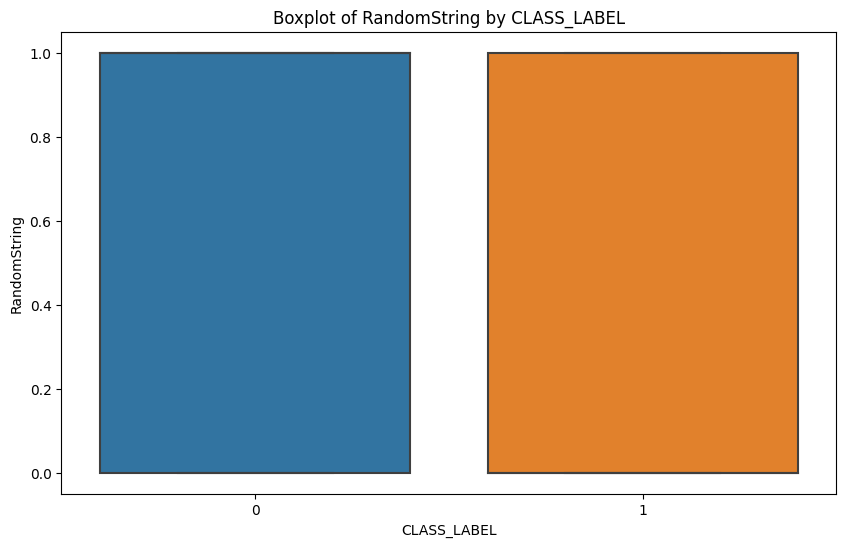

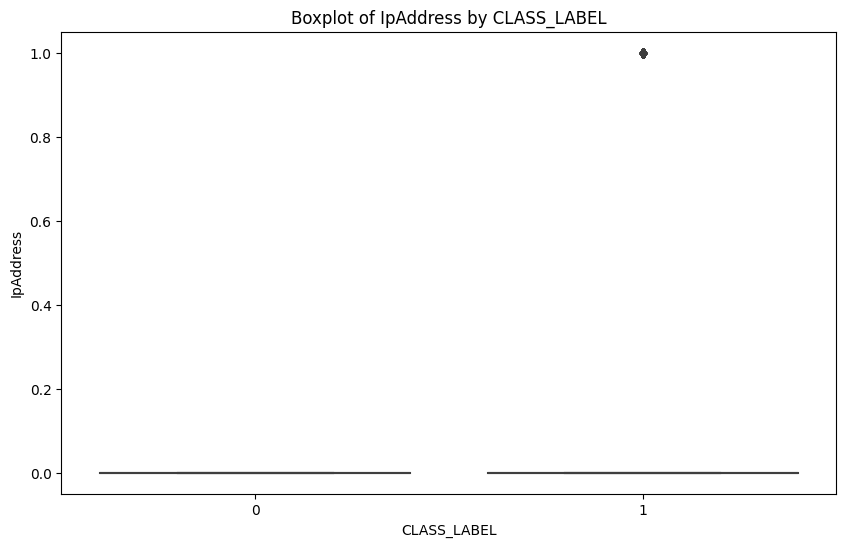

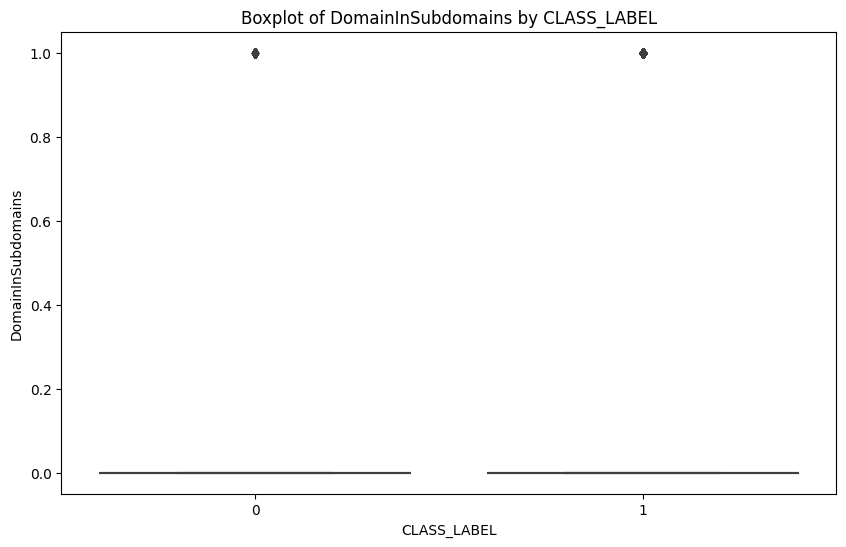

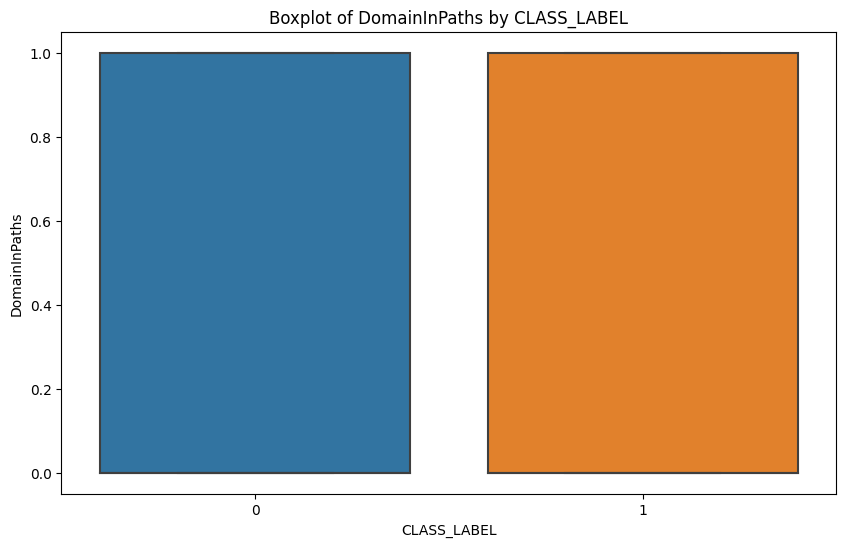

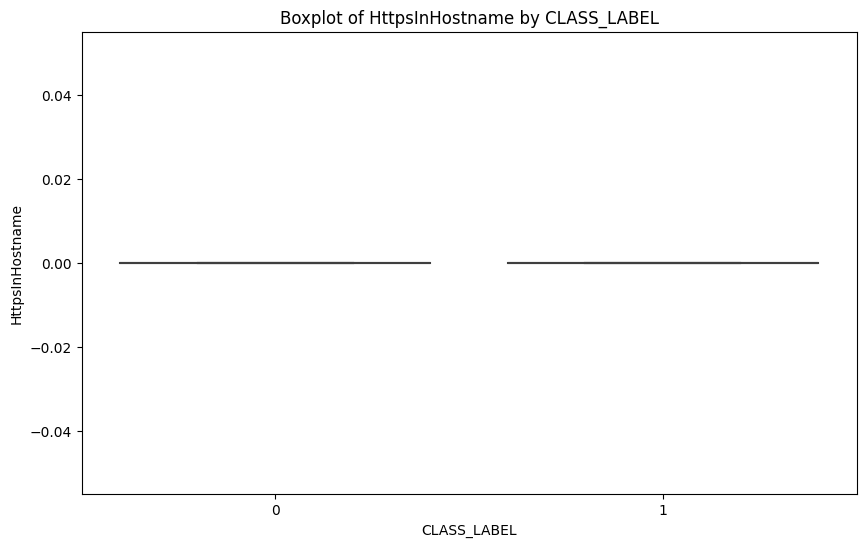

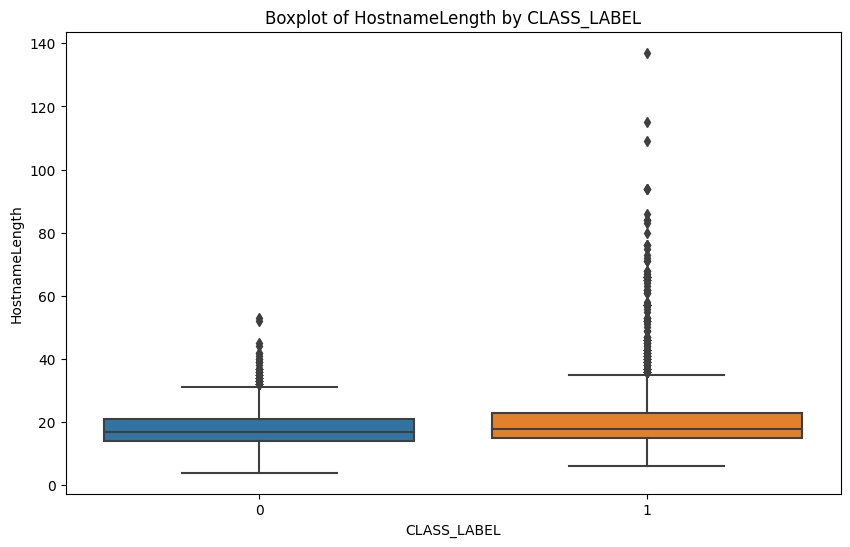

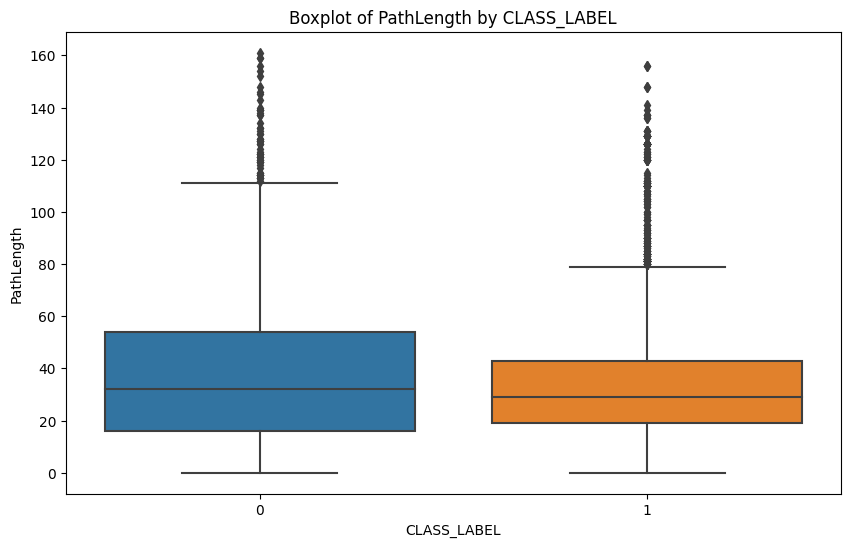

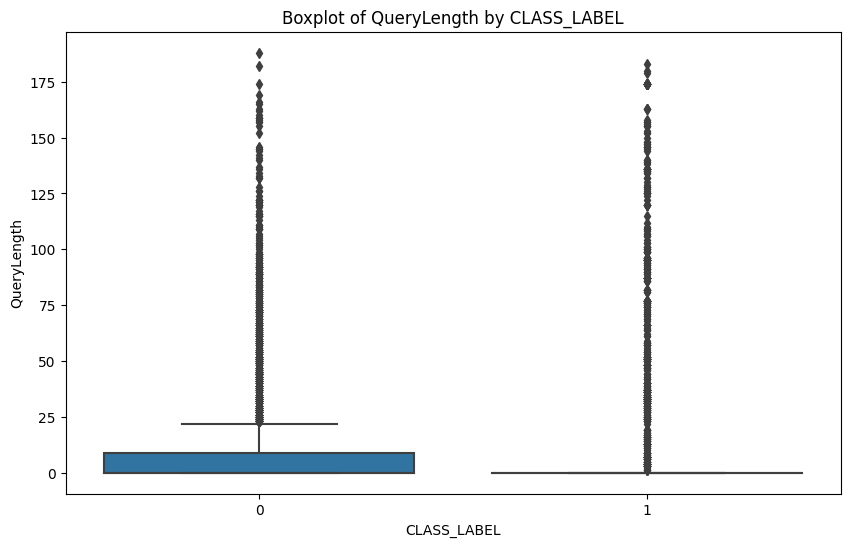

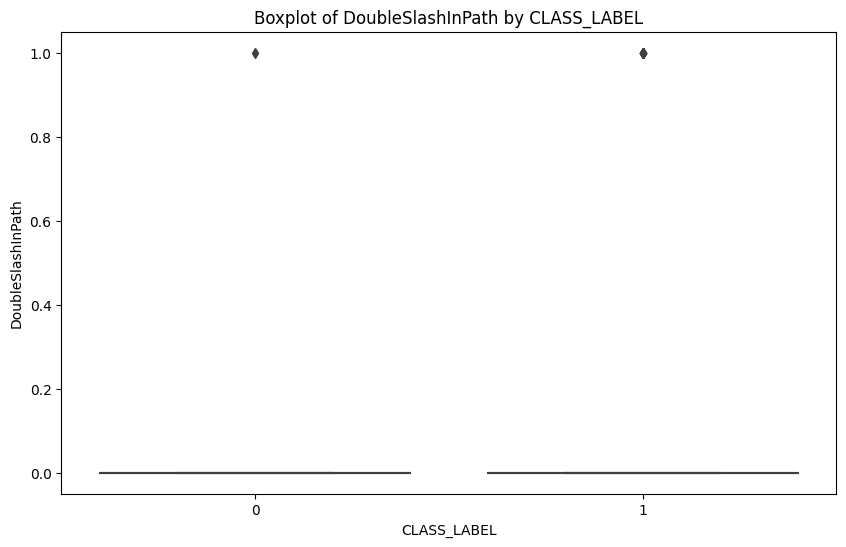

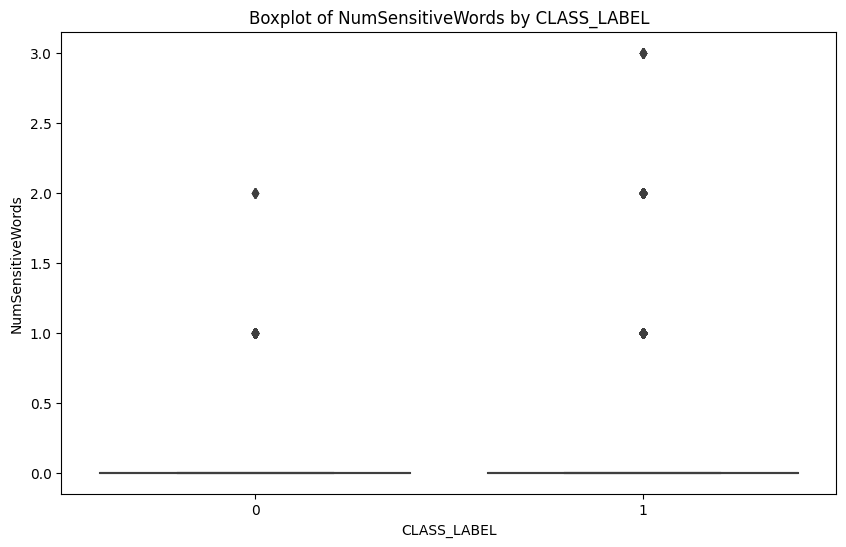

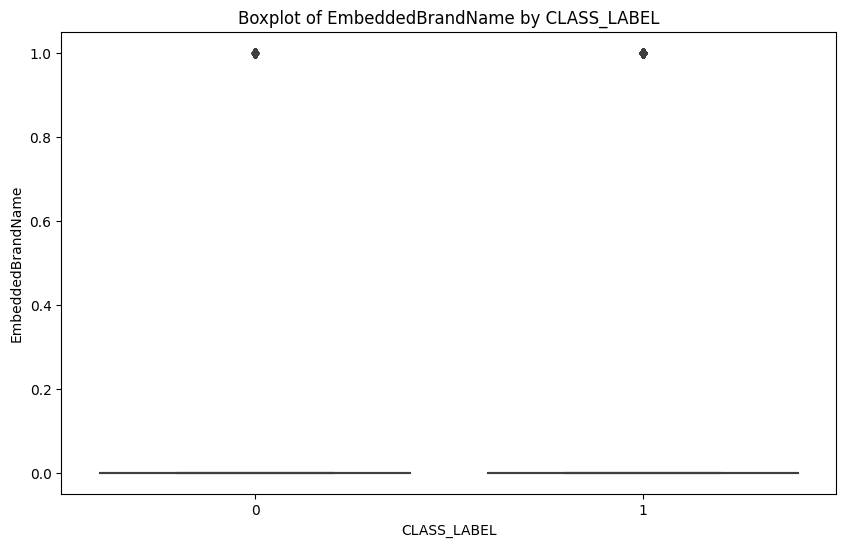

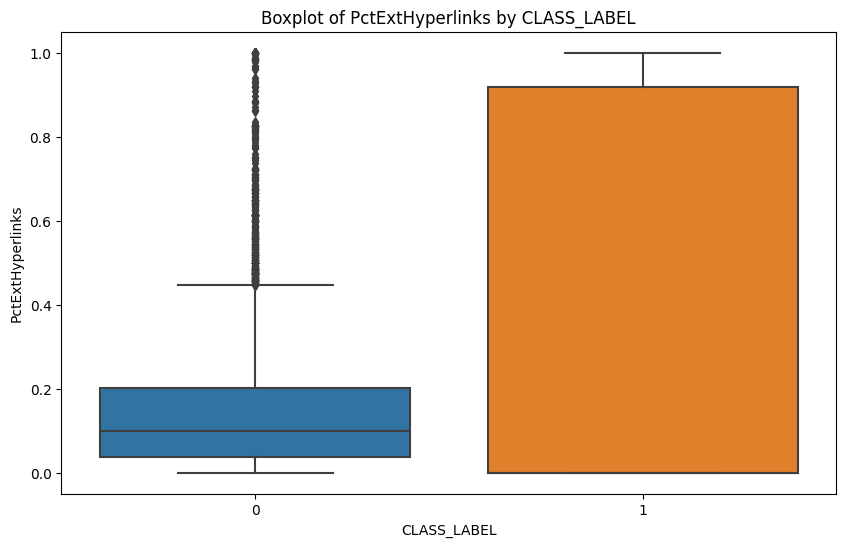

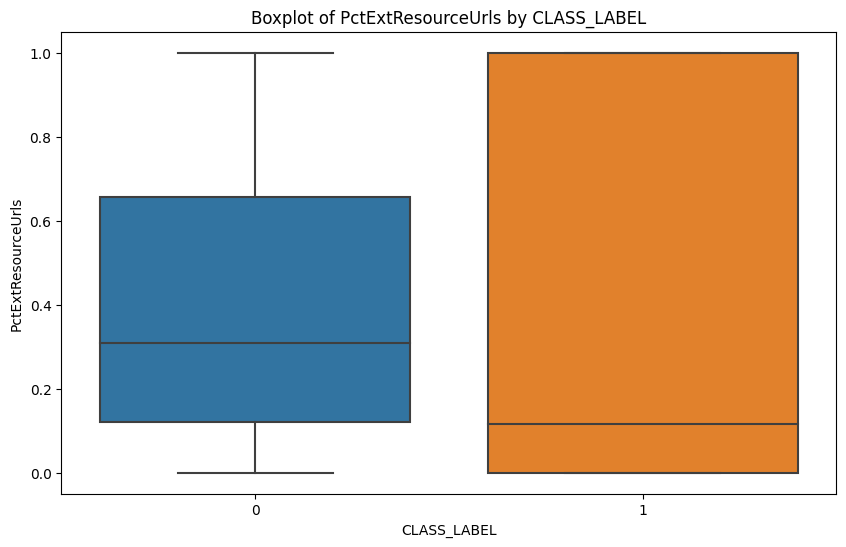

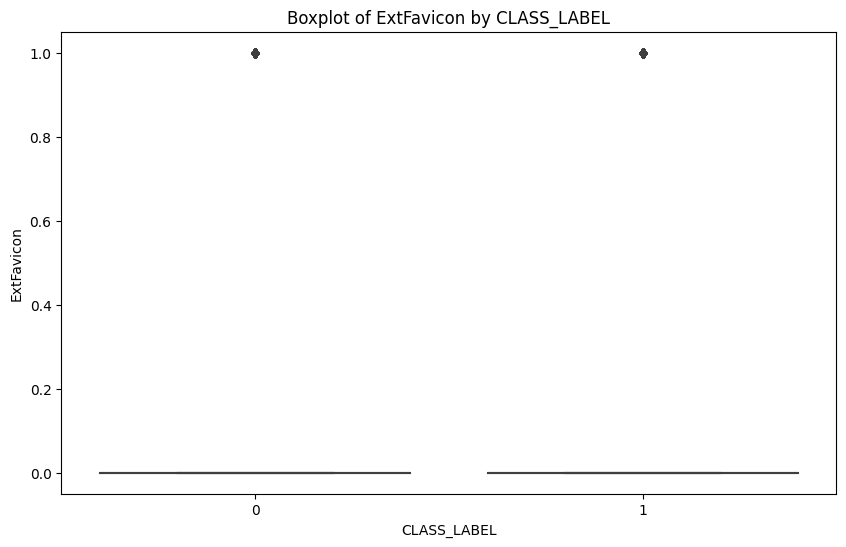

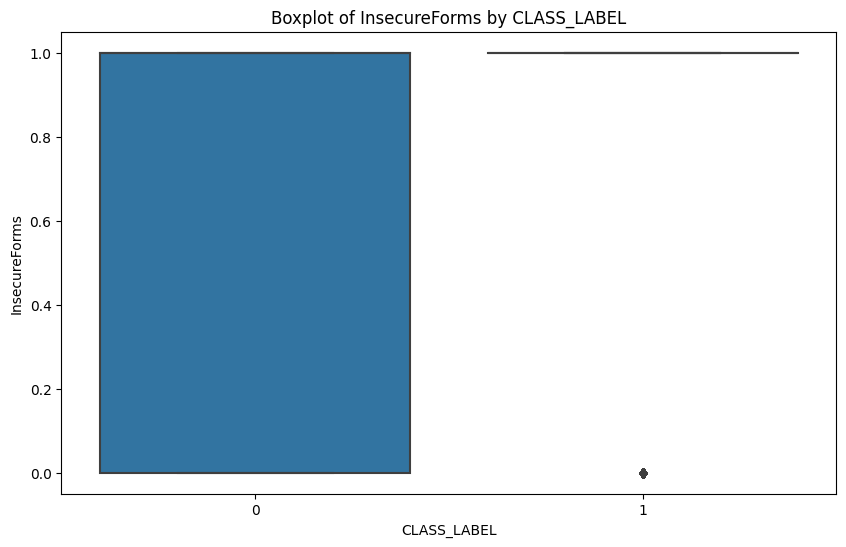

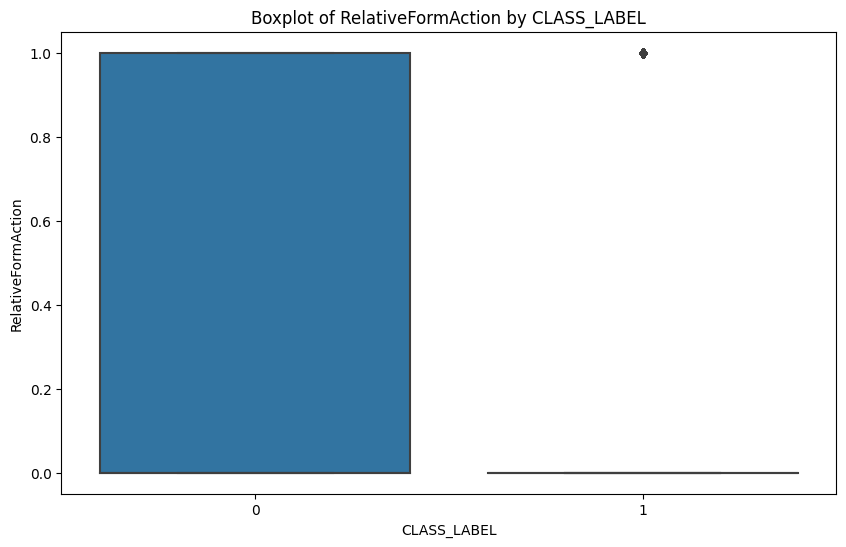

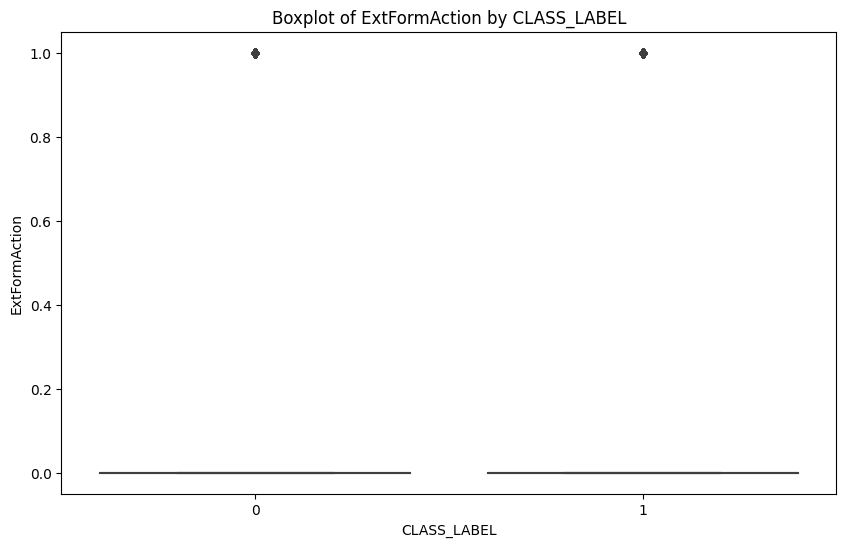

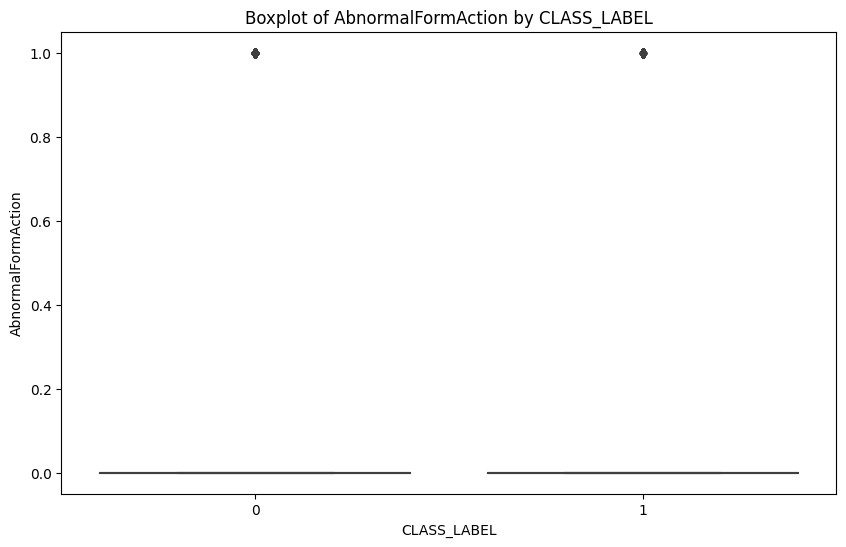

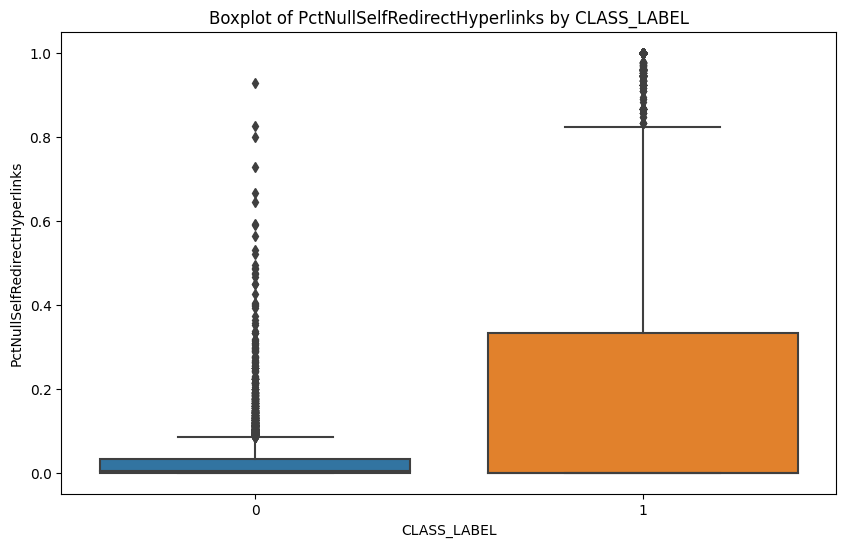

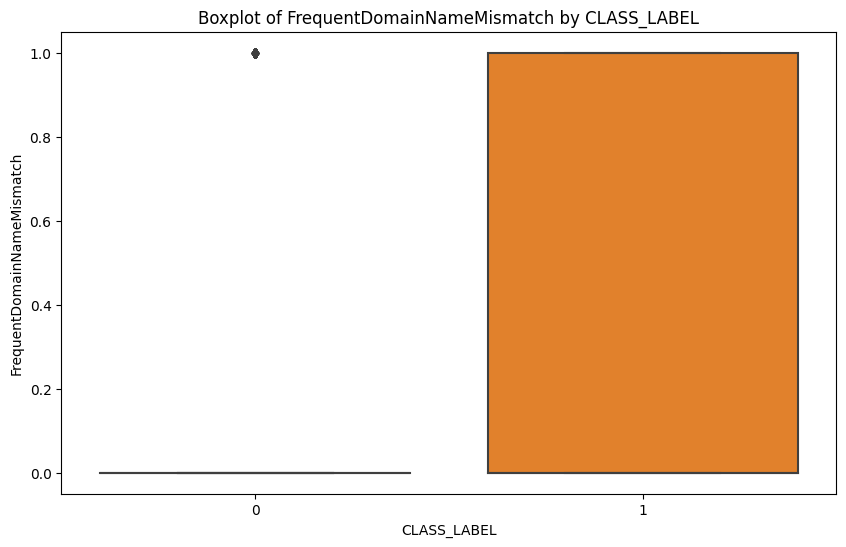

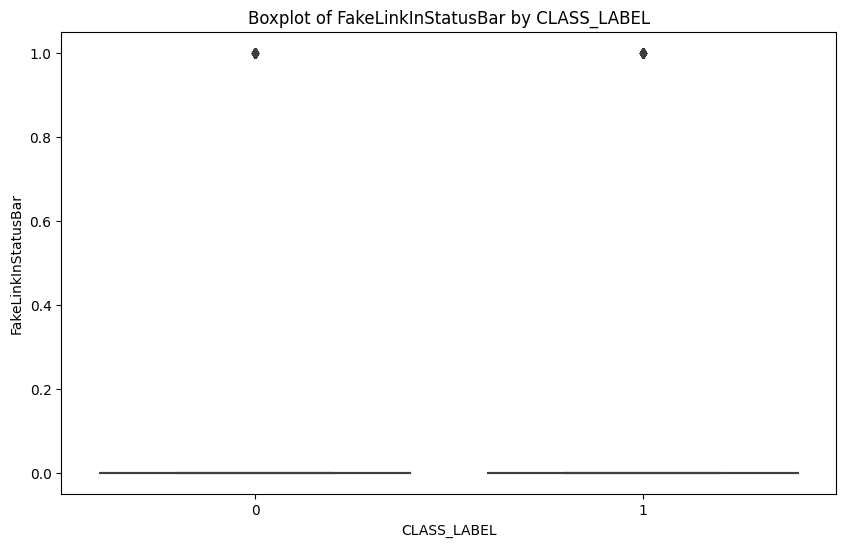

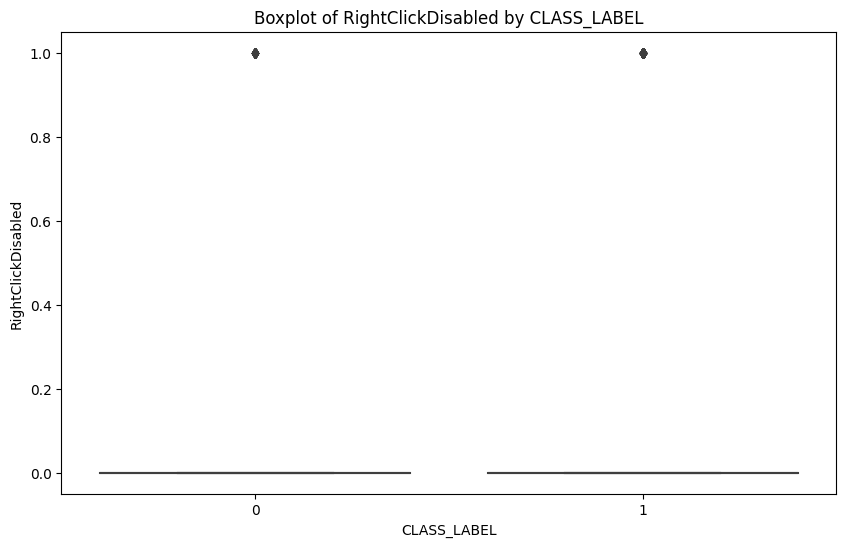

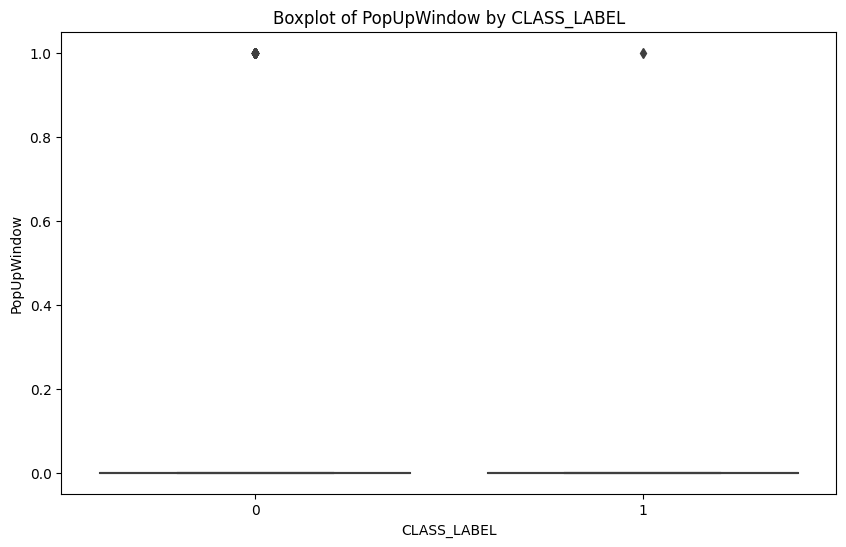

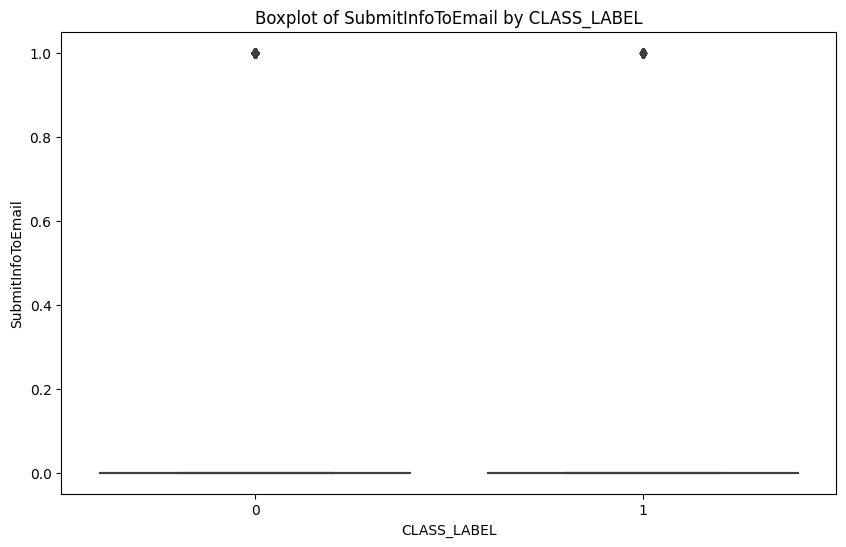

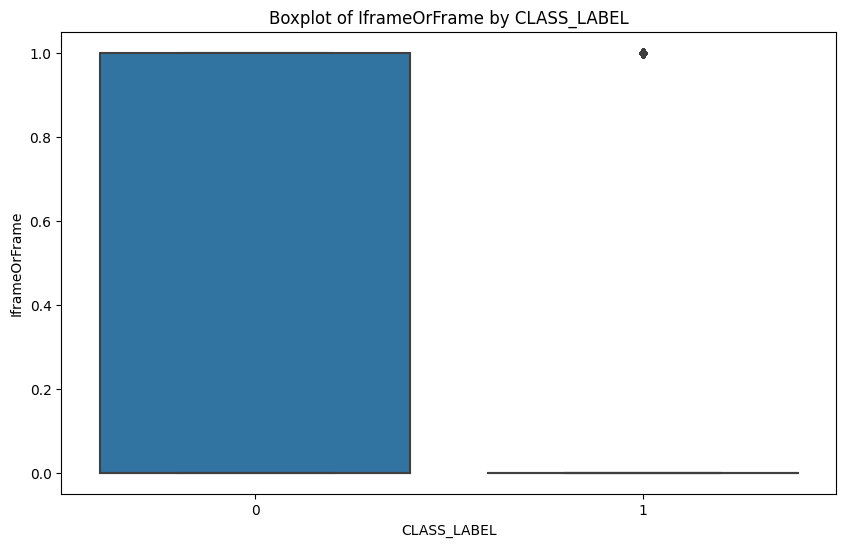

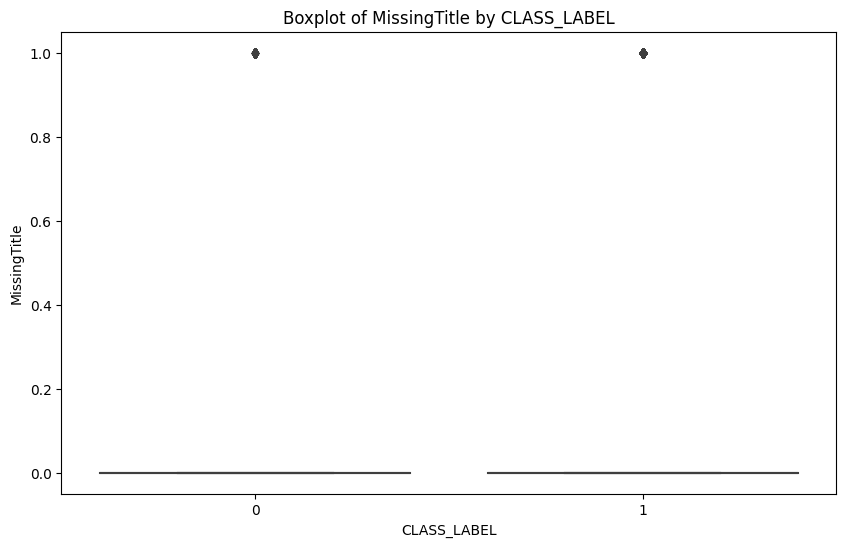

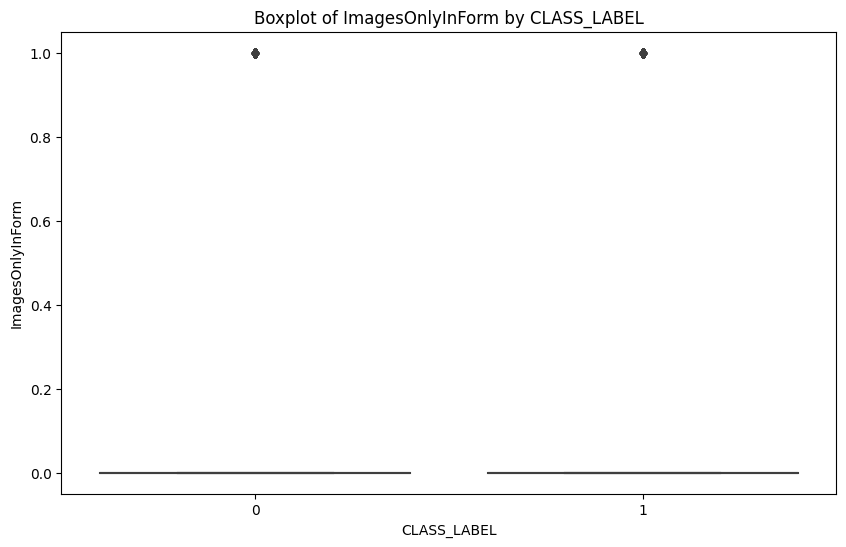

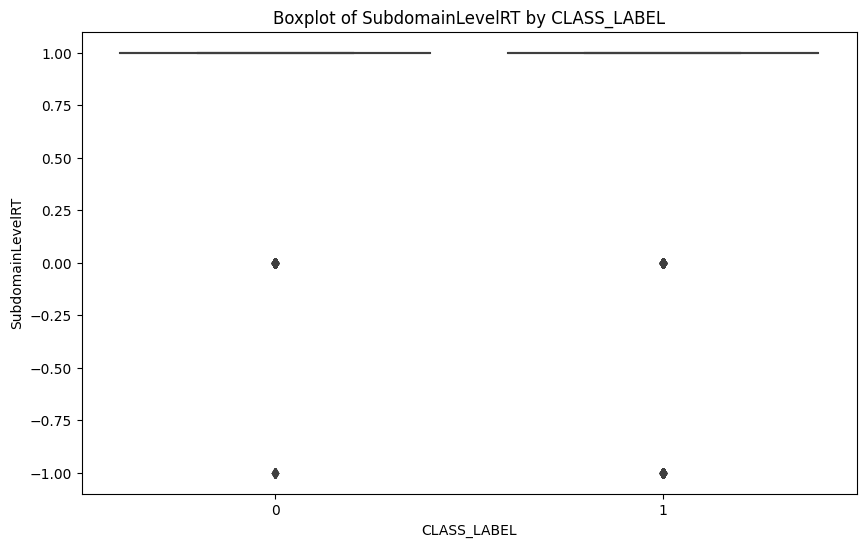

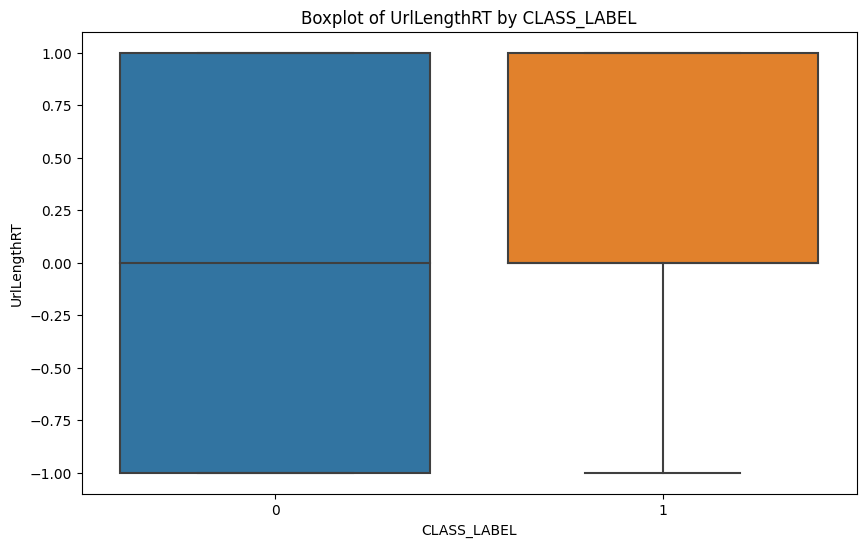

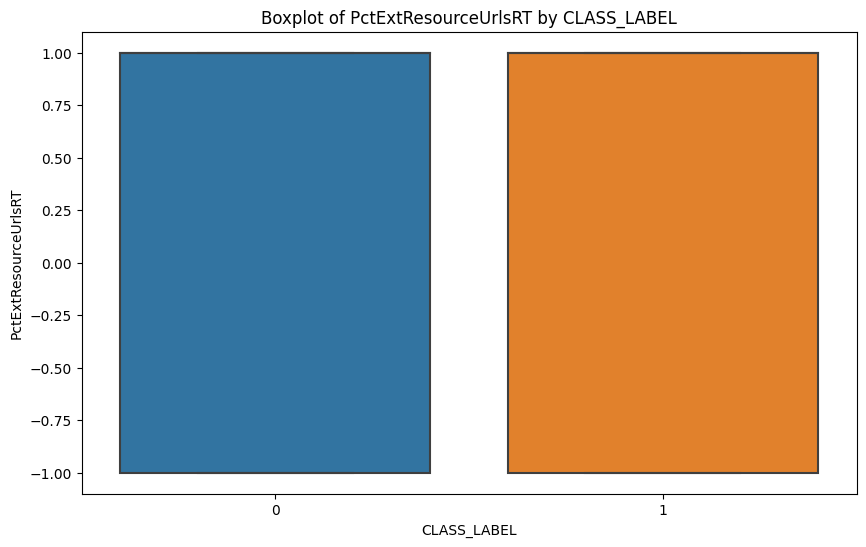

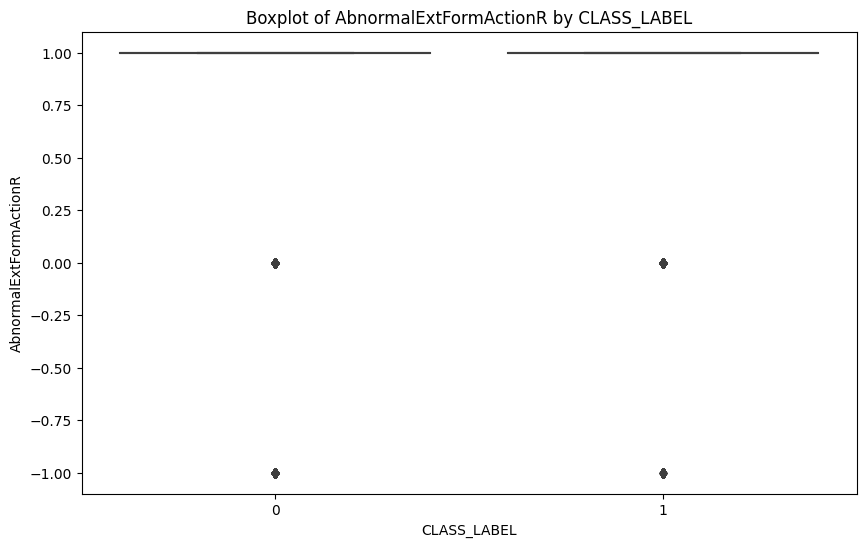

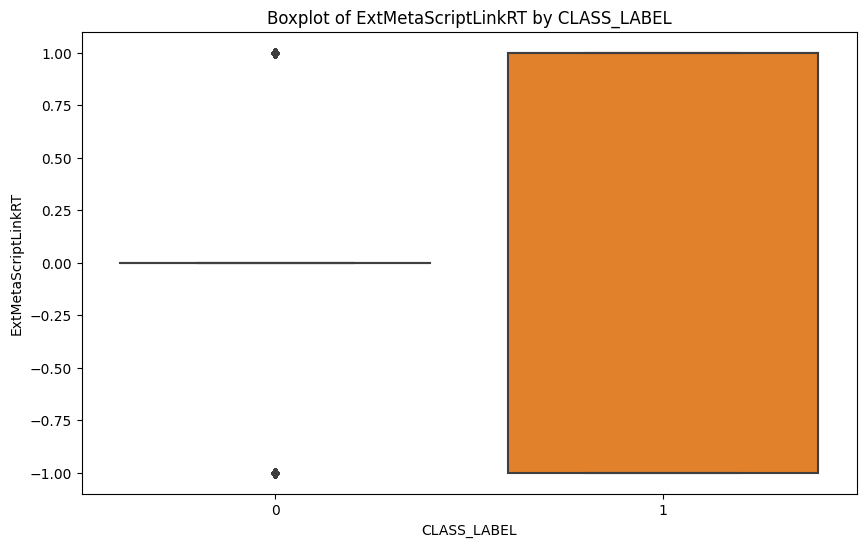

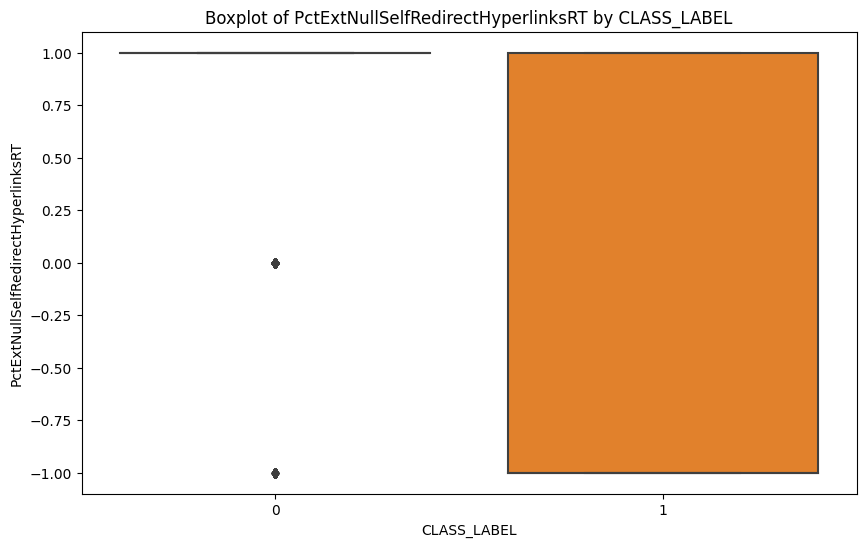

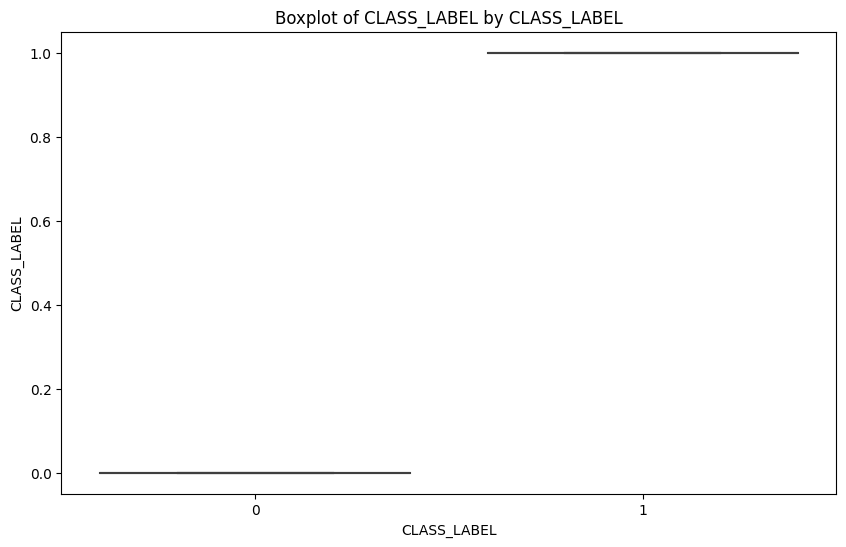

In [72]:
# Boxplots for all numeric features based on the target variable
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='CLASS_LABEL', y=column, data=df)
    plt.title(f'Boxplot of {column} by CLASS_LABEL')
    plt.show()


## **Stage # 2:** ```Feature Engineering```

### **Mutual Info**

We will use mutual info classifier to find non linear and linear correlation betweem the features and labels

In [73]:
X = df.drop(['CLASS_LABEL'], axis=1)
y = df['CLASS_LABEL']


This line of code identifies discrete features by checking if their data types are integers (int). It creates a boolean array (discrete_features) where True indicates that the corresponding feature is of integer type, suggesting it's likely a discrete variable.

In [74]:
discrete_features = X.dtypes == int

Here we process the scores and we can see that now mutual info is showing a bit different list from spearman corr.

In [75]:
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

PctExtHyperlinks                      0.472167
PctExtResourceUrls                    0.289379
PctNullSelfRedirectHyperlinks         0.234874
PctExtNullSelfRedirectHyperlinksRT    0.209900
NumNumericChars                       0.138342
FrequentDomainNameMismatch            0.125169
ExtMetaScriptLinkRT                   0.114637
NumDash                               0.112845
SubmitInfoToEmail                     0.081597
NumDots                               0.063555
PathLevel                             0.060448
PathLength                            0.060364
QueryLength                           0.054315
InsecureForms                         0.054015
UrlLength                             0.040687
NumSensitiveWords                     0.039096
NumQueryComponents                    0.034738
IframeOrFrame                         0.030312
AbnormalExtFormActionR                0.026286
PctExtResourceUrlsRT                  0.025721
HostnameLength                        0.020751
NumAmpersand 


Sorting and displaying Mutual Information (MI) scores in a horizontal bar plot, this function, plot_mi_scores, gives a visual rundown of feature importance. The figure is tailored for clarity, providing a quick insight into the significance of each feature in the dataset.

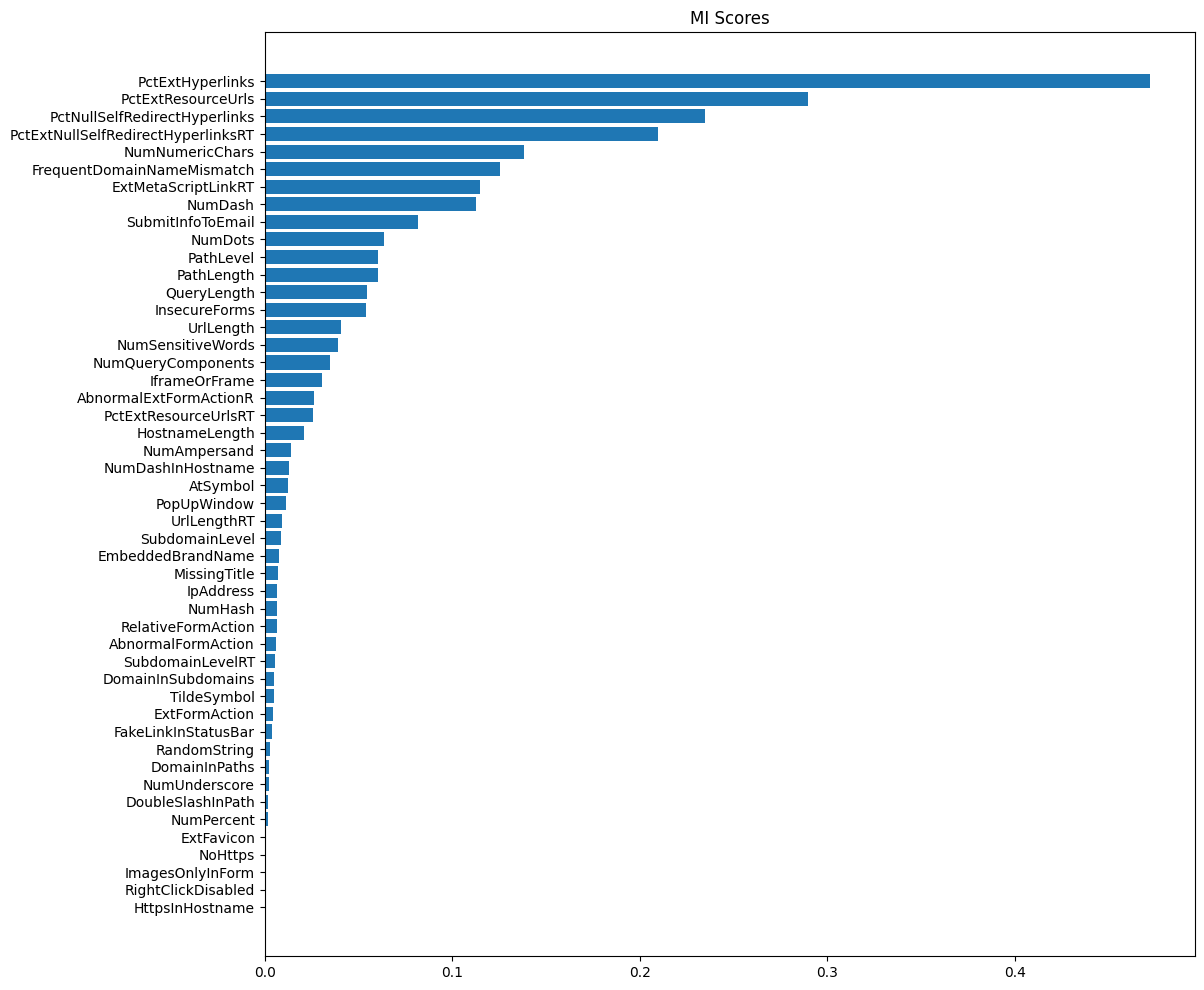

In [76]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Scores")
    
plt.figure(dpi=100, figsize=(12,12))
plot_mi_scores(mi_scores)

## **Stage # 3:** ```Model Implementation```

### **Initializing**
Dropping rows with missing values for simplicity, the dataset is prepared by separating features and the target variable. Subsequently, the data is split into training and testing sets using an 80-20 ratio. To ensure compatibility with logistic regression, feature standardization is applied using StandardScaler on both the training and testing sets. This standardized data is now ready for model training and evaluation.

In [77]:
# Drop any rows with missing values for simplicity (handle missing values as needed in practice)
df = df.dropna()

# Features
X = df.drop('CLASS_LABEL', axis=1)

# Target variable
y = df['CLASS_LABEL']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Model # 1:** ```Logistic Regression```

Here, a logistic regression model is trained using the scaled training data (X_train_scaled and y_train), and subsequently, predictions are made on the scaled test data (X_test_scaled). This process sets the stage for evaluating the model's performance and assessing its predictive capabilities.

In [78]:
# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
logistic_predictions = logistic_model.predict(X_test_scaled)

### Evaluating the model
The accuracy, precision, recall, and F1 score of the logistic regression model are calculated by comparing its predictions (logistic_predictions) with the actual target values in the test set (y_test). Additionally, the confusion matrix is computed to provide a detailed breakdown of the model's classification performance, offering insights into true positives, true negatives, false positives, and false negatives.

In [79]:
# Evaluate the model
accuracy1 = accuracy_score(y_test, logistic_predictions)
precision = precision_score(y_test, logistic_predictions)
recall = recall_score(y_test, logistic_predictions)
f1 = f1_score(y_test, logistic_predictions)
conf_matrix = confusion_matrix(y_test, logistic_predictions)

### Visualizing Confusion Matrix
The confusion matrix is visualized for a clear understanding of the model's predictive behavior. The resulting metrics provide a comprehensive view of how well the logistic regression model performs in distinguishing between legitimate and phishing instances.

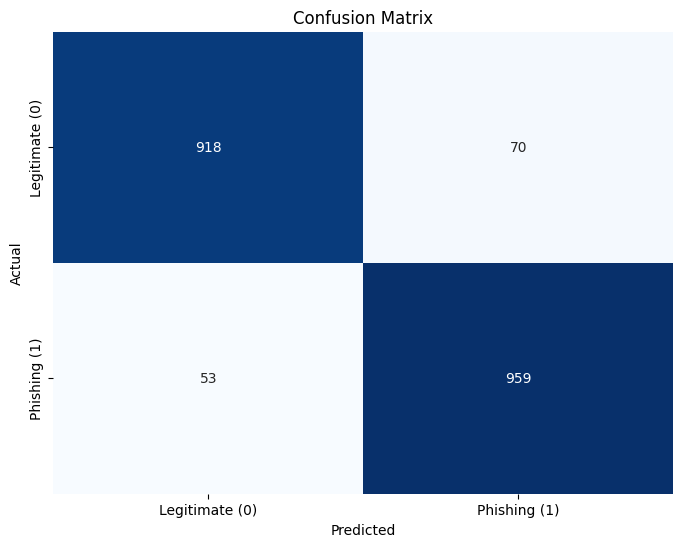

In [80]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate (0)', 'Phishing (1)'],
            yticklabels=['Legitimate (0)', 'Phishing (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Displaying performance metrics

In [81]:
print(f"Accuracy: {accuracy1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9385
Precision: 0.9320
Recall: 0.9476
F1 Score: 0.9397


### **Model # 2:** ```Support Vector Machine (SVM)```

In [82]:
# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)

### Evaluating the model

In [83]:
# Evaluate the model
accuracy2 = accuracy_score(y_test, svm_predictions)
precision = precision_score(y_test, svm_predictions)
recall = recall_score(y_test, svm_predictions)
f1 = f1_score(y_test, svm_predictions)
conf_matrix = confusion_matrix(y_test, svm_predictions)

### Visualizing Confusion Matrix

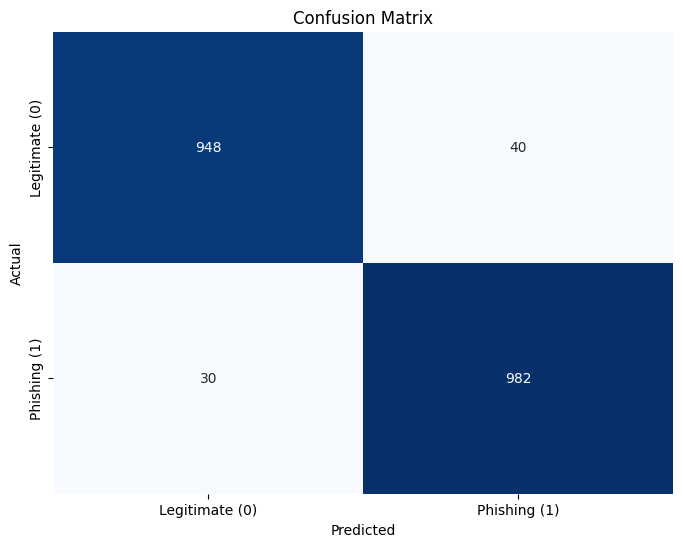

In [84]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate (0)', 'Phishing (1)'],
            yticklabels=['Legitimate (0)', 'Phishing (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Displaying performance metrics

In [85]:
# Display performance metrics
print(f"Accuracy: {accuracy2:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9650
Precision: 0.9609
Recall: 0.9704
F1 Score: 0.9656


### **Model # 3:** ```Decission Tree```

In [86]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)
dt_predictions = dt_model.predict(X_test_scaled)

### Evaluating the model

In [87]:
accuracy3 = accuracy_score(y_test, dt_predictions)
precision = precision_score(y_test, dt_predictions)
recall = recall_score(y_test, dt_predictions)
f1 = f1_score(y_test, dt_predictions)
conf_matrix = confusion_matrix(y_test, dt_predictions)

### Visualizing Confusion Matrix

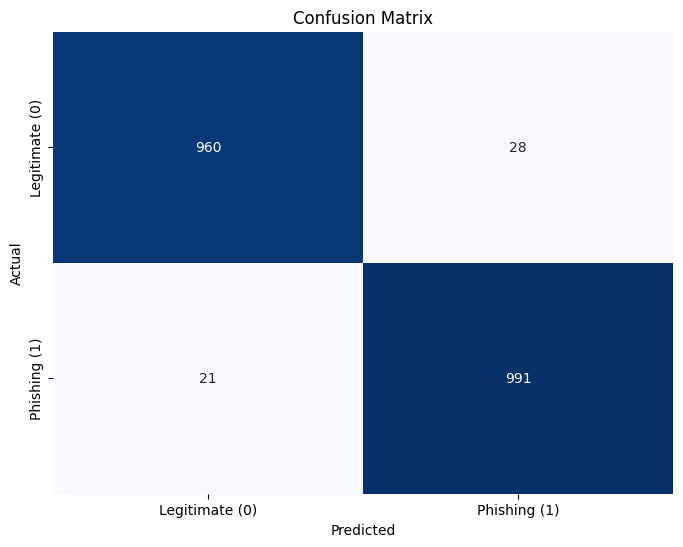

In [88]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate (0)', 'Phishing (1)'],
            yticklabels=['Legitimate (0)', 'Phishing (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Displaying performance metrics

In [89]:
print(f"Accuracy: {accuracy3:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9755
Precision: 0.9725
Recall: 0.9792
F1 Score: 0.9759


### **Model # 4:** ```Random Forest```

In [90]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

### Evaluating the model

In [91]:
accuracy4 = accuracy_score(y_test, rf_predictions)
precision = precision_score(y_test, rf_predictions)
recall = recall_score(y_test, rf_predictions)
f1 = f1_score(y_test, rf_predictions)
conf_matrix = confusion_matrix(y_test, rf_predictions)

### Visualizing Confusion Matrix

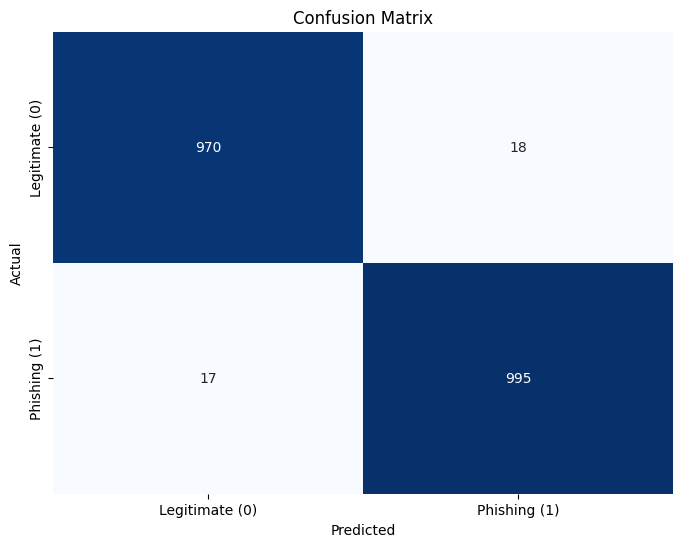

In [92]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate (0)', 'Phishing (1)'],
            yticklabels=['Legitimate (0)', 'Phishing (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Displaying performance metrics

In [93]:
print(f"Accuracy: {accuracy4:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9825
Precision: 0.9822
Recall: 0.9832
F1 Score: 0.9827


### **Model # 5:** ```XGBOOST```

In [94]:
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)
xgb_predictions = xgb_model.predict(X_test_scaled)

### Evaluating the model

In [95]:
accuracy5 = accuracy_score(y_test, xgb_predictions)
precision = precision_score(y_test, xgb_predictions)
recall = recall_score(y_test, xgb_predictions)
f1 = f1_score(y_test, xgb_predictions)
conf_matrix = confusion_matrix(y_test, xgb_predictions)

### Visualizing Confusion Matrix

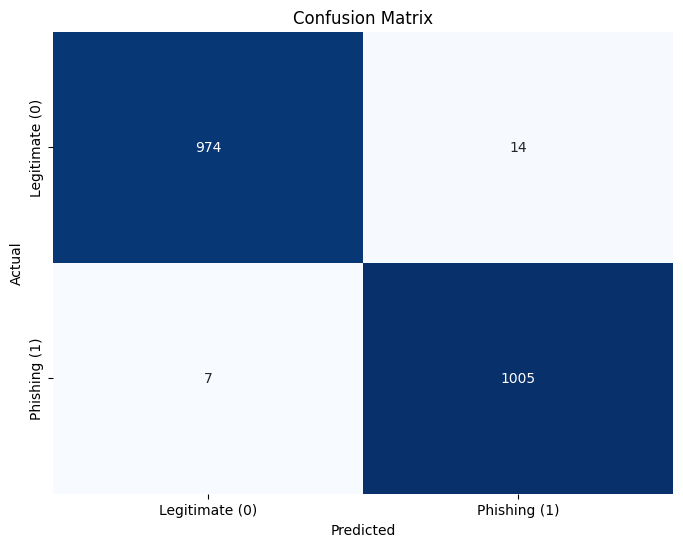

In [96]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate (0)', 'Phishing (1)'],
            yticklabels=['Legitimate (0)', 'Phishing (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Displaying performance metrics

In [97]:
print(f"Accuracy: {accuracy5:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9895
Precision: 0.9863
Recall: 0.9931
F1 Score: 0.9897


### **Comparing the Models**

Collecting rhe accuracy for each model

In [98]:
model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]

### Creating a **Bar-Graph**

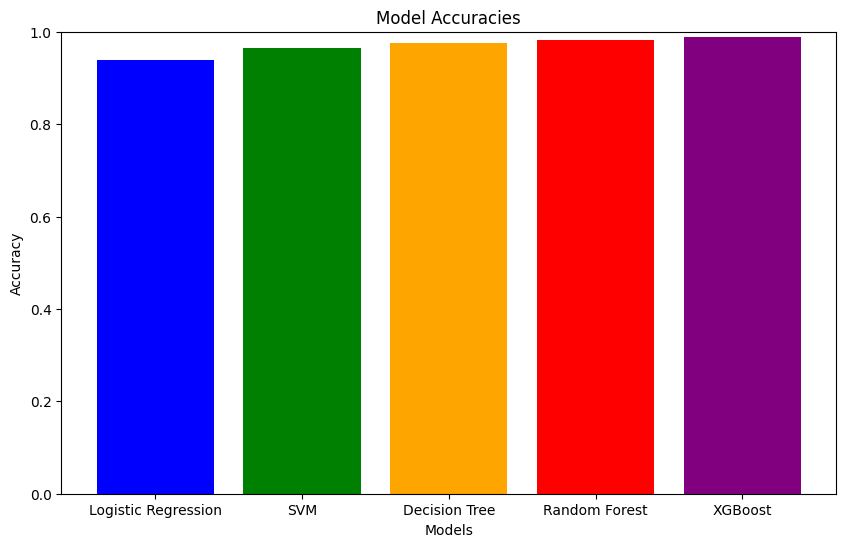

In [99]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy values
plt.show()

## **Stage # 4:** ```Pickel Format Saving```



Pickle format is useful for saving and loading Python objects, like machine learning models, due to its serialization capabilities, cross-version compatibility, and ease of use.

In [100]:
model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5]
models = [logistic_model, svm_model, dt_model, rf_model, xgb_model]

### Selecting the model with highest accuracy

In [101]:
# Finding the index of the model with the highest accuracy
best_model_index = accuracies.index(max(accuracies))

# Get the best model and its name
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Save the best model using pickle
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print(f"The best model ({best_model_name}) has been saved as 'best_model.pkl'")

The best model (XGBoost) has been saved as 'best_model.pkl'


In [102]:
# Load the test data
test_data = pd.read_csv("D:/Hegtavic/Phishing FYP/Phishing_Legitimate_test.csv")

# Load the model
rfc_model = joblib.load("D:/Hegtavic/Phishing FYP/best_model.pkl")

# Features
X_test = test_data.drop('CLASS_LABEL', axis=1)

# Make predictions
predictions = rfc_model.predict(X_test)

print(predictions)

[0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
